In [9]:
import os
import pyemu
import CV_tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime
import flopy.utils.binaryfile as bf
from shutil import copyfile
%matplotlib inline
#%matplotlib notebook #allows zooming, but opens many figures

flopy is installed in C:\conda3x64\envs\p3x64\lib\site-packages\flopy


In [10]:
cft2Mm3=1/(3.28084**3)/1.0e6

extdir=r'S:\kitlasten2020_wrr\model\external_files\Carson_Valley'

In [11]:
def get_scens():
    outdir=r'S:\kitlasten2020_wrr\output'
    scens={'0C':os.path.join(outdir,'output_MSGSF_0C'),
                 '1C':os.path.join(outdir,'output_MSGSF_1C'),
                 '2C':os.path.join(outdir,'output_MSGSF_2C'),
                 '3C':os.path.join(outdir,'output_MSGSF_3C'),
                 '4C':os.path.join(outdir,'output_MSGSF_4C'),
                 '5C':os.path.join(outdir,'output_MSGSF_5C'),
                 'hist':os.path.join(outdir,'output_MSGSF_hist')}
    scenlist=['0C','1C','2C','3C','4C','5C','hist']
    return(scenlist,scens)

In [12]:
scenlist,scens=get_scens()
simstart=datetime.date(1979,7,2)
simstop=datetime.date(2015,9,30)
irrmo=[4,5,6,7,8,9]
scend8s=pd.date_range('1980-10-1','2015-9-30',freq='D')
scenyrs=scend8s.year.unique()
figsize=(10,5)

In [13]:
#New WR acres
#get irrigation acres from wr_cell_frac
# cell frac in pandas
celldf=pd.read_csv(os.path.join(extdir,'wr_cell_frac.txt'))
celldf.columns=celldf.columns.str.lower()
celldf.wrname=celldf.wrname.apply(lambda x: x.lower().replace('_',''))
celldf.set_index('wrname',inplace=True)
celldf.drop(['unnamed: 0'],axis=1,inplace=True)
celldf['row']=celldf['row']-1
celldf['col']=celldf['col']-1
wracres=celldf.loc[:,'wr_acres']
wracres=wracres.groupby(by='wrname').mean()

In [14]:
def get_wrdf(irrfile,wracres):
    with open(irrfile,'r') as f:
        head=f.readline().replace('#','').strip().replace('  ',' ').replace('  ',' ').split(' ')
    
    irr=pd.read_csv(irrfile,skiprows=[0],names=head,delim_whitespace=True)
    irr.index=irr.WRname.str.lower()
    irr.drop('WRname',inplace=True,axis=1)
#wrfile='CV-wes-8015trans-WRtable.txt'
# ONLY do this if irr doesn't have wryr
#with open(wrfile,'r') as f:
#    head=f.readline().replace('#','').strip(' ').strip().replace('  ',' ').split(' ')
#wr=pd.read_csv(wrfile,skiprows=[0],names=head,delim_whitespace=True)
#wr.index=wr.WRname.str.lower()
#wr.drop(['WRname','desc','acres','row','col'],inplace=True,axis=1)
#wrdf=irr.merge(wr,left_on='WRname',right_on='WRname')
#wrdf.to_csv(irrfile,sep=' ',na_rep=('NA'))
    wrdf=irr.copy(deep=True)
    wrdf=wrdf.groupby(['WRname']).mean() #gets rid of duplicates by averaging, also drops any non-numeric data not in by
    wrdf.index=wrdf.index.str.lower()
    wrdf['acres']=wracres
    
    # get proper CA WRYR
    propwryr={'478-481': 1864,'487': 1891,'488-490': 1891,'491': 1893,'492-501': 1881,
              '502-507': 1871,'508': 1890,'509-510': 1884,'511': 1893,'512': 1894,
              '513-514': 1864,'515': 1864,'516-517': 1864,'517a': 1871,'518-519': 1864,
              '520-522': 1892,'523-527': 1885,'528': 1894,'529-531': 1866,'532-533': 1865,'534': 1885,'535-536': 1859}
    for wr in propwryr:
        wrdf.loc[wr,'wryr']=propwryr[wr]

    
    
    wrdf.head()
    return(wrdf)

In [15]:
def sumtab(pst,e,real='base'):
    '''this is for ensembles only, i.e. pest during calibration period'''
    pie=[]
    plab=[]
    res={}
    ensemble=(pst.filename.replace('pst','.{}.{}.csv'.format(e,'obs')).replace('..','.').replace('..','.')) #double dot for noptmax=0
    if os.path.exists(ensemble):
        try:
            pen=pd.read_csv(ensemble.replace('obs','par'),low_memory=False)
            pen.set_index('real_name',inplace=True)
            pen=pen.T
        except:
            pen=pd.read_csv(ensemble.replace('obs.csv','base.par'),index_col=0,
                            low_memory=False,header=0,names=['parnme','base'],usecols=[0,1],delim_whitespace=True)
            
            
        en=pd.read_csv(ensemble,low_memory=False)
        en.set_index('real_name',inplace=True)
        en=en.T
        en.columns=en.columns.astype(str)
        
        print(ensemble)
    elif 'rns'==e: #ensemble name is dumb
        #try intermediate partial ensemble from rns
        #does not contain lambda test results, only "remaining ensemble" reals
        rns=pyemu.utils.read_pestpp_runstorage(pst.filename.replace('.pst','.rns'),irun='all')
        done=[r for r in rns[1].index if rns[1].loc[r,:].mean()!=0]
        pen=rns[0].loc[done,:]
        en=rns[1].loc[done,:]
        pen=pen.T
        en=en.T
        en.columns=en.columns.astype(str)
        
        print('using rns file {} with {} reals complete'.format(pst.filename.replace('.pst','.rns'),len(en.columns)))
    if real=='base':
        try:
            sim=en.loc[:,'base']
        except:
            sim=en.loc[:,:].mean(axis=1)
            print('cannot find base real, using mean')
    elif real=='mean':
        sim=en.loc[:,:].mean(axis=1)
    tres=[]
    print('GROUP CONTRIBUTIONS TO PHI ({})'.format(real))
    for g in sorted(list(set(obs['obgnme']))):
        mask=[o for o in obs.index if obs.loc[o,'obgnme']==g]
        res[g]=(sim.loc[mask]-obs.loc[mask,'obsval']).to_frame()
        res[g].columns=['res']
        if 'less_' not in g:
            wres=(res[g].loc[:,'res']*obs.loc[mask,'weight'])**2
        else:
            m=[i for i in mask if obs.loc[i,'obsval']<sim.loc[i]]
            wres=(res[g].loc[m,'res']*obs.loc[m,'weight'])**2
        print('{0:<20}: sum={1:>10.2e}, std={2:>10.2e}'.format(g,wres.sum(),wres.std()))
        pie.append(wres.sum())
        plab.append(g)
        tres.append(wres.sum())
    total=np.sum(tres)
    print('total {0:.2e}, {1:.2e}'.format(total,np.std(tres)))
    plt.pie(pie,labels=plab)
    plt.show()
    en['res_real']=sim
    return(pen,en,res)
    

In [16]:
wrdf=get_wrdf(os.path.join(extdir,'CV-wes-8015trans-irrigation-fracsup.txt'),wracres)
wrdf.head(10)

,iseg,wellnum,welllay,wellrow,wellcol,startyr,dpt,swu,swufrac,pctsup,swfrfrac,swfr,welleff,wryr,row,col,acres
WRname,,,,,,,,,,,,,,,,,
056,998,NaN,NaN,NaN,NaN,NaN,0.010929,0.007726,0.767833,NaN,0.993391,0.999725,NaN,1880.0,158.0,84.0,1.9875
057a,1051,NaN,NaN,NaN,NaN,NaN,0.027982,0.051638,0.774693,NaN,0.907559,0.089143,NaN,1889.0,155.0,85.0,97.0679
058a,1157,NaN,NaN,NaN,NaN,NaN,0.022108,0.007892,0.855151,NaN,0.854737,0.108686,NaN,1916.0,150.0,86.0,99.7208
059,999,NaN,NaN,NaN,NaN,NaN,0.158524,0.020658,0.866762,NaN,0.872975,0.693674,NaN,1880.0,159.0,84.0,6.2327
060,1116,NaN,NaN,NaN,NaN,NaN,0.156815,0.024127,0.924215,NaN,0.857488,0.753628,NaN,1900.0,159.0,83.0,12.5040
061,1052,2.0,4.0,151.0,76.0,1981.333333,0.000052,0.092544,0.900002,0.81,0.878824,0.211569,0.367081,1889.0,152.0,78.0,38.3758
063,743,NaN,NaN,NaN,NaN,NaN,0.101008,0.031664,0.883223,NaN,0.791365,0.492795,NaN,1860.0,155.0,77.0,162.1254
064,762,5.0,4.0,151.0,76.0,1981.333333,0.015966,0.023146,0.797631,0.81,0.929672,0.963813,0.373743,1861.0,150.0,76.0,104.5396
065,905,8.0,4.0,151.0,76.0,1981.333333,0.018496,0.019191,0.850717,0.81,0.856266,0.979470,0.566241,1875.0,148.0,78.0,40.8601


## scenario results

In [17]:
#run post procs, takes a while
#sim_wrts_extract_final.py

# WARNING "SW-RIGHT" in swgag file does NOT match demand tabs or MODSIM demands

In [18]:
# get ET data from post-proc
etdf={}

scenlist,scens=get_scens()

resdir=r'S:\kitlasten2020_wrr\results_dT'
if not os.path.exists(resdir):
    os.mkdir(resdir)
    
#get et from post-processor annual cubic feet (pre-proc pcpet incorporated in same sim_wret_ts.txt file)
for scen in scenlist:
    if not os.path.exists(os.path.join(resdir,scen)):
        os.mkdir(os.path.join(resdir,scen))
    df=pd.read_csv(os.path.join(scens[scen],'sim_wret_ts.txt'),delim_whitespace=True,usecols=[0,1,2,3,4,5],index_col=False)
    
    d8str=df.loc[:,'obnme'].str.split('_').str.get(-1)+'0101'
    df['yr']=pd.to_datetime(d8str,format='%y%m%d')
    df['wr']=df.loc[:,'obnme'].str.split('_',1).str.get(1).str.rsplit('_',1).str.get(0)
    df['wr_yr']=df.loc[:,'obnme'].str.split('_',1).str.get(1)
    df=df.merge(wrdf,left_on='wr',right_on='WRname')
    etdf[scen]=df.copy(deep=True)
    
#get deliv from post-processed file (annual cubic feet)
for scen in scenlist:
    df=pd.read_csv(os.path.join(scens[scen],'sim_swgag_ts.txt'),delim_whitespace=True,usecols=[0,1,2,3,4],index_col=False)
    d8str=df.loc[:,'obnme'].str.split('_').str.get(-1)+'0101'
    df['yr']=pd.to_datetime(d8str,format='%y%m%d')
    df['wr']=df.loc[:,'obnme'].str.split('_',1).str.get(1).str.rsplit('_',1).str.get(0)
    df['wr_yr']=df.loc[:,'obnme'].str.split('_',1).str.get(1)
    df.drop(['obnme','yr','wr'],inplace=True,axis=1)
    etdf[scen]=df.merge(etdf[scen],left_on='wr_yr',right_on='wr_yr')
#     etdf[scen]=deliv.loc[:,['0C_del']].merge(etdf[scen],left_on='wr',right_on='wr')
    
    
#data frame for each wr and each yr
pd.set_option('precision', 3)
for scen in scenlist:
    #these now in feet per year
    bscen='0C'
    etdf[scen]['tot_et_fpy']=etdf[scen]['total_wr_et']/etdf[scen]['acres']/43560
    etdf[scen]['tot_del_fpy']=etdf[scen]['tot_del']/etdf[scen]['acres']/43560
    etdf[scen]['sw_del_fpy']=etdf[scen]['sw_del']/etdf[scen]['acres']/43560
    etdf[scen]['well_del_fpy']=etdf[scen]['well_del']/etdf[scen]['acres']/43560

    etdf[bscen]['tot_et_fpy']=etdf[bscen]['total_wr_et']/etdf[bscen]['acres']/43560
    etdf[bscen]['tot_del_fpy']=etdf[bscen]['tot_del']/etdf[bscen]['acres']/43560
    etdf[bscen]['sw_del_fpy']=etdf[bscen]['sw_del']/etdf[bscen]['acres']/43560
    etdf[bscen]['well_del_fpy']=etdf[bscen]['well_del']/etdf[bscen]['acres']/43560
    
    # difference from 0C
    etdf[scen].index=etdf[scen].obnme
    etdf[bscen].index=etdf[bscen].obnme
    etdf[scen]['tot_et_fpy_scen_0C']=etdf[scen]['tot_et_fpy']-etdf[bscen]['tot_et_fpy']
    etdf[scen]['tot_et_volume_scen_0C']=etdf[scen]['total_wr_et']-etdf[bscen]['total_wr_et']
    etdf[scen]['tot_del_scen_0C']=etdf[scen]['tot_del']-etdf[bscen]['tot_del']
    etdf[scen]['sw_del_scen_0C']=etdf[scen]['sw_del']-etdf[bscen]['sw_del']
    etdf[scen]['well_del_scen_0C']=etdf[scen]['well_del']-etdf[bscen]['well_del']
    etdf[scen]['tot_del_fpy_scen_0C']=etdf[scen]['tot_del_fpy']-etdf[bscen]['tot_del_fpy']
    etdf[scen]['sw_del_fpy_scen_0C']=etdf[scen]['sw_del_fpy']-etdf[bscen]['sw_del_fpy']
    etdf[scen]['well_del_fpy_scen_0C']=etdf[scen]['well_del_fpy']-etdf[bscen]['well_del_fpy']
    
    etdf[scen].drop('wr_yr',inplace=True,axis=1)
    
    mask=[i for i in etdf[scen].index if etdf[scen].loc[i,'tot_et_fpy']>4]
    print('{0} has {1:.1f} ft3 et by WR with rate > 4 ft/yr'.format(scen,etdf[scen].loc[mask,'total_wr_et'].divide(43560).mean())) #average volume leaving from WR with ET>4 in ac-ft/yr


0C has 360.9 ft3 et by WR with rate > 4 ft/yr
1C has 376.1 ft3 et by WR with rate > 4 ft/yr
2C has 376.2 ft3 et by WR with rate > 4 ft/yr
3C has 392.9 ft3 et by WR with rate > 4 ft/yr
4C has 405.0 ft3 et by WR with rate > 4 ft/yr
5C has 414.8 ft3 et by WR with rate > 4 ft/yr
hist has 497.6 ft3 et by WR with rate > 4 ft/yr


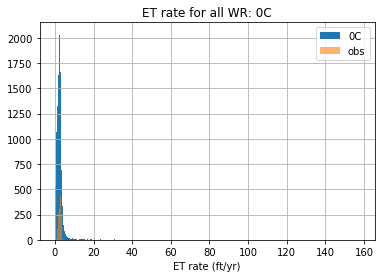

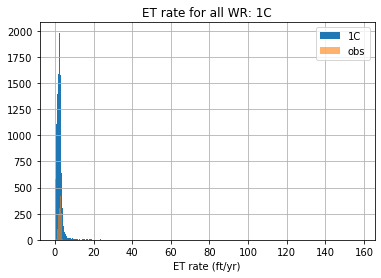

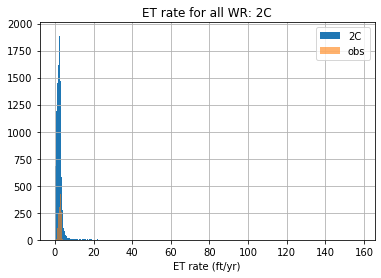

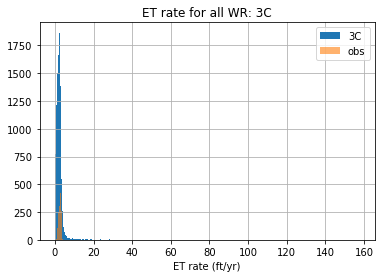

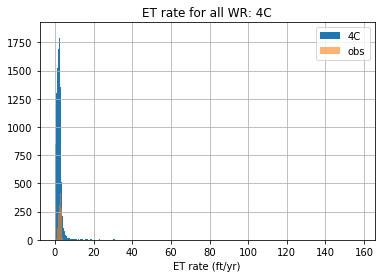

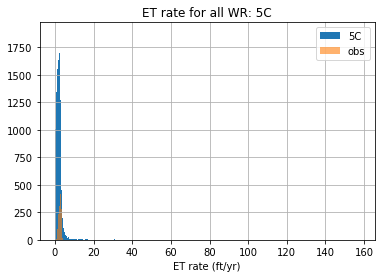

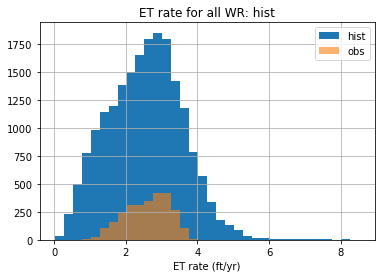

In [19]:
# get results from pest to compare obs
pestname='CV_cal_finalpars.pst'
pst=pyemu.Pst(os.path.join(r'S:\kitlasten2020_wrr\ancillary\pest',pestname))
obs=pst.observation_data
for scen in scenlist:
    etdf[scen].hist('tot_et_fpy',bins=np.arange(etdf[scen]['tot_et_fpy'].min(),etdf[scen]['tot_et_fpy'].max(),0.25))
    plt.title('ET rate for all WR: {}'.format(scen))
    plt.xlabel('ET rate (ft/yr)')
    wrrtobs=[o for o in obs.index if obs.loc[o,'obgnme']=='wrrt']
    obs.loc[wrrtobs,'obsval'].hist(bins=np.arange(etdf[scen]['tot_et_fpy'].min(),etdf[scen]['tot_et_fpy'].max(),0.25),alpha=0.6)
    plt.legend([scen,'obs'])
    plt.show()

In [20]:
#write etdf file, copy inflow results (check agains intabs), build df of mean values for each WR
mdflist=[]
wrcols=['acres','tot_del','sw_del','well_del','total_wr_et','swet','wellet','gwet','pcpet','pctsup','wryr',
        'tot_del_scen_0C','sw_del_scen_0C','well_del_scen_0C',
        'tot_del_fpy_scen_0C','sw_del_fpy_scen_0C','well_del_fpy_scen_0C',
        'tot_et_fpy_scen_0C','tot_et_volume_scen_0C']
for scen in scenlist:
    print(scen)
    etdf[scen].to_csv(os.path.join(resdir,scen,scen+'_etdf.csv'),columns=[c for c in wrcols])
    mdf=etdf[scen].groupby('wr').mean() #wr becomes index, don't include in cols
    mdf.to_csv(os.path.join(resdir,scen,scen+'_mean_etdf.csv'),columns=[c for c in wrcols])
    copyfile(os.path.join('..\\','runs',scens[scen],'CV-wes-8015trans-10311000.sgag'),os.path.join(resdir,scen,scen+'-10311000.sgag'))
    copyfile(os.path.join('..\\','runs',scens[scen],'CV-wes-8015trans-10309000.sgag'),os.path.join(resdir,scen,scen+'-10309000.sgag'))
    copyfile(os.path.join('..\\','runs',scens[scen],'CV-wes-8015trans-10310000.sgag'),os.path.join(resdir,scen,scen+'-10310000.sgag'))
    
    mdf.columns=['dT'+scen+'_'+c for c in mdf.columns]
    mdflist.append(mdf[['dT'+scen+'_sw_del_fpy_scen_0C','dT'+scen+'_well_del_fpy_scen_0C','dT'+scen+'_tot_del_fpy_scen_0C','dT'+scen+'_tot_et_fpy_scen_0C']])

0C
1C
2C
3C
4C
5C
hist


In [21]:
#define wr decades and WR with rotations
wrdec=[0,1850,1860,1870,1880,1890,1900,2000]
wrdeclab=['1850s\nand prior','1860s','1870s','1880s','1890s','1900s\nand later']
rotwr=['544','578','559','532-533','604','555','554','557','556','553','516-517','492-501','491','529-531','542','558','535-536','523-527','543','540','534','546','508','545','528','561','513-514','568','540a','560','518-519','562','563','564','502-507','566','565','517a','487','567','478-481','520-522','537','488-490','539','511','512','515','509-510','538']
etdf[scen]['wrdec']=False
for scen in etdf:
    for i,d in enumerate(wrdec):
        mask=[x for x in etdf[scen].index if wrdec[i]<=etdf[scen].loc[x,'wryr']<wrdec[i+1]]
        #leave "real" decade, lump prior to 1850 into 1850
        etdf[scen].loc[mask,'wrdecade']=d
        etdf[scen].loc[mask,'wrdec']=max(1850,d)

In [22]:
etdf['0C'].loc[:,'sw_dmd'].sum()/1000000

368394.524265521

In [23]:
etdf['1C'].loc[:,'sw_dmd'].sum()/1000000

416810.3547485831

In [24]:
#construct intermediate dfs for rates, volumes, and percentages of sw, wells, and total
nyrs=36.22221218331232
sw={}
well={}
tot={}
vsw={}
vwell={}
vtot={}
psw={}
pwell={}
ptot={}
for scen in ['1C','2C','3C','4C','5C']:
    #depth based, mean (already normalized by acres)
    decdf=etdf[scen].loc[:,:].groupby('wrdec').mean()
    
    well[scen]=decdf.loc[:,'well_del_fpy_scen_0C']
    sw[scen]=decdf.loc[:,'sw_del_fpy_scen_0C']
    tot[scen]=decdf.loc[:,'tot_del_fpy_scen_0C']

#volume based total delivery, sum all in decade, divide by years for average volume
basedf=etdf['0C'].loc[:,:].groupby('wrdec').sum()
for scen in ['1C','2C','3C','4C','5C']:
    decdf=etdf[scen].loc[:,:].groupby('wrdec').sum()/43560/nyrs #is in cf, convert to ac-ft on the fly, divide by 36 year sim period
    
    vwell[scen]=decdf.loc[:,'well_del_scen_0C']
    vsw[scen]=decdf.loc[:,'sw_del_scen_0C']
    vtot[scen]=decdf.loc[:,'tot_del_scen_0C']
    
    pwell[scen]=(decdf.loc[:,'well_del_scen_0C'].divide(basedf.loc[:,'well_del']))*100
    psw[scen]=(decdf.loc[:,'sw_del_scen_0C'].divide(basedf.loc[:,'sw_del']))*100
    ptot[scen]=(decdf.loc[:,'tot_del_scen_0C'].divide(basedf.loc[:,'tot_del']))*100
    

Text(0.5, 0, 'priority decade')

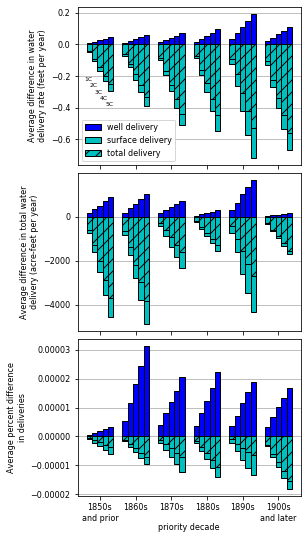

In [25]:
# Change in deliveries figure
fs=8
fig,ax=plt.subplots(3,1,figsize=(4,9),gridspec_kw = {'wspace':0, 'hspace':0.05})
for i,(t,m) in enumerate(zip(['Average difference in water\ndelivery rate (feet per year)',
                              'Average difference in total water\ndelivery (acre-feet per year)',
                              'Average percent difference\nin deliveries'],[[well,sw,tot],[vwell,vsw,vtot],[pwell,psw,ptot]])):
    pd.DataFrame(m[0]).plot(kind='bar',ax=ax[i],legend=False,color='b',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[1]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[2]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',hatch='//',sharex=True,fontsize=fs,width=0.75)

    ax[i].grid(True,which='major',axis='y')
    ax[i].set_axisbelow(True)
    
    ax[i].set_ylabel(t,fontsize=fs)

#ax[0].set_title('Difference in deliveries to water rights by decade',fontsize=fs+2)
for x,y,dtlab in zip([-0.45,-0.3,-0.15,0,0.16],[-0.23,-0.27,-0.31,-0.35,-0.39],['1C','2C','3C','4C','5C']):
    ax[0].text(x,y,dtlab,fontsize=fs-2,rotation=0)
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[0:len(h):5],['well delivery','surface delivery','total delivery'],loc=3,fontsize=fs)
ax[i].xaxis.set_major_formatter(ticker.FixedFormatter(wrdeclab))        
plt.setp(ax[i].get_xticklabels(), rotation=0)
ax[i].set_xlabel('priority decade',fontsize=fs,labelpad=0)
#plt.savefig(r'S:\CarsonValley\manuscripts\kitlasten_2020_final_figures\Figure 6 priority decade fpy.eps', format='eps')

# get demand time series for each scenario
dmd={}
for scen in scenlist:
    for fn in os.listdir(os.path.join(modir,'MSGSF','MSGSF_'+scen,'tabfiles_'+scen)):
        if 'demand' in fn:
            data=fn.split('-')
            if len(data)==7:
                wr=data[4].lower()
            elif len(data)==8:
                wr='-'.join(data[4:6]).lower()
            else:
                print('yerdum {}'.format(derp))
            ts=pd.read_csv(os.path.join(modir,'MSGSF','MSGSF_'+scen,'tabfiles_'+scen,fn),delim_whitespace=True, usecols=[0,1,3],names=['simday','dmd','date'])
            ts['date']=pd.to_datetime(ts['date'])
            ts.set_index('date',inplace=True)
            ats=ts.resample('D').interpolate(method='backfill')
            dmd[wr]=ats['dmd'].mean()
dmddf=pd.DataFrame.from_dict(dmd,orient='index',columns=['dmd'])

In [26]:
# convert to Mm3
hmdflist=[]
Metdf={}
cuft2Mm3=1/((3.28084**3)*1.0e6)
wrcols=['acres','tot_del','sw_del','well_del','total_wr_et','swet','wellet','gwet','pcpet','pctsup','wryr','wrdec',
        'tot_del_scen_0C','sw_del_scen_0C','well_del_scen_0C',
        'tot_del_mpy_scen_0C','sw_del_mpy_scen_0C','sw_del_pct_scen_0C','well_del_mpy_scen_0C',
        'tot_et_mpy_scen_0C','tot_et_volume_scen_0C','tot_et_pct_scen_0C']

for scen in scenlist:
    Metdf[scen]=etdf[scen].copy(deep=True)
    Metdf[scen]['Mm2']=etdf[scen]['acres'].multiply(43560/(3.28084**2)/1.0e6) #convert acres to Mm^2
    Metdf[scen][['tot_del','sw_del','sw_dmd','well_del','total_wr_et','swet','wellet','gwet','pcpet',
                'tot_del_scen_0C','sw_del_scen_0C','well_del_scen_0C',
                'tot_et_volume_scen_0C']]=etdf[scen][['tot_del','sw_del','sw_dmd','well_del',
                'total_wr_et','swet','wellet','gwet','pcpet',
                'tot_del_scen_0C','sw_del_scen_0C','well_del_scen_0C',
                'tot_et_volume_scen_0C']].multiply(cuft2Mm3)
    Metdf[scen][['tot_del_mpy_scen_0C','sw_del_mpy_scen_0C','well_del_mpy_scen_0C',
                'tot_et_mpy_scen_0C']]=etdf[scen][['tot_del_fpy_scen_0C','sw_del_fpy_scen_0C',
                'well_del_fpy_scen_0C','tot_et_fpy_scen_0C']].divide(3.28084)
    
for scen in scenlist:
    Metdf[scen]['sw_del_pct_scen_0C']=Metdf[scen]['sw_del_scen_0C'].divide(Metdf['0C']['sw_del'])
    Metdf[scen]['tot_et_pct_scen_0C']=Metdf[scen]['tot_et_volume_scen_0C'].divide(Metdf['0C']['total_wr_et'])
    Metdf[scen].to_csv(os.path.join(resdir,scen,'dT'+scen+'_etdf_Mcmy.csv'),columns=[c for c in wrcols])
    hmdf=Metdf[scen].groupby('wr').mean() # mean value for wr. wr becomes index, don't include in cols
    
    
    
    hmdf.to_csv(os.path.join(resdir,scen,'dT'+scen+'_mean_etdf_Mm3y.csv'),float_format='%.4f',columns=[c for c in wrcols])
    hmdf.columns=['dT'+scen+'_'+c for c in hmdf.columns]
    hmdflist.append(hmdf[['dT'+scen+'_sw_del_mpy_scen_0C','dT'+scen+'_sw_del_pct_scen_0C','dT'+scen+'_tot_et_pct_scen_0C','dT'+scen+'_well_del_mpy_scen_0C','dT'+scen+'_tot_del_mpy_scen_0C','dT'+scen+'_tot_et_mpy_scen_0C']])

In [71]:
decreed=[i.lower() for i in wrdf.index if wrdf.loc[i,'wryr']>1800]
decet=[i for i in Metdf[scen].index if Metdf[scen].loc[i,'wr'].lower() in decreed]

In [85]:
for q in ['sw_del','swet','tot_del','total_wr_et','well_del','wellet','gwet','sw_dmd']:    
    print('\nmean annual {}\n'.format(q))
    for scen in ['hist','0C','1C','2C','3C','4C','5C']:
        print('{}'.format(float(Metdf[scen].loc[decet,['yr',q]].groupby('yr').sum().mean())))#,float(Metdf[scen].loc[:,['yr',q]].groupby('yr').sum().max()),float(Metdf[scen].loc[:,['yr',q]].groupby('yr').sum().min())))


mean annual sw_del

118.27490002175523
116.40713680218202
112.8020654247079
108.70677612621004
104.37418461437838
100.05810639152055
95.63135581384078

mean annual swet

27.531570851485682
26.420991465021157
25.598474418341564
24.753287446942288
23.986295244784497
23.071366951128404
22.14455592474815

mean annual tot_del

125.57129083600333
130.99649308799863
128.32033062619135
125.24827035710524
122.01156763492071
118.72402699362296
115.37872662501248

mean annual total_wr_et

131.353904799905
104.2363903793681
101.98152128726979
99.45028484495559
96.7520577955127
93.91767947706833
90.95578090895268

mean annual well_del

7.29639081425108
14.58935628581373
15.51826520154456
16.541494230895182
17.637383020542327
18.66592060210237
19.747370811171688

mean annual wellet

2.256962877764209
6.583761021672271
6.972265989112029
7.412630634986495
7.886226369442813
8.32916263903297
8.79811619102257

mean annual gwet

74.356915120027
68.85246653028655
67.03160951742443
64.90519540063505
62.500

# WARNING "SW-RIGHT" in swgag file does NOT match demand tabs or MODSIM demands

In [73]:
# get dmds from tabfiles dir
dmd={}
for scen in ['hist','0C','1C','2C','3C','4C','5C']:
    wrdmd=[]
    for fname in os.listdir(os.path.join('..\\..\\','model','MSGSF_'+scen,'tabfiles_'+scen)):
        if 'demand' in fname:
            wr=fname.split('-',4)[-1].rsplit('-',2)[0].lower()
            if wr.replace('_rot','') in [w.lower() for w in decreed]:
                wrdmd.append(pd.read_csv(os.path.join('..\\..\\','model','MSGSF_'+scen,'tabfiles_'+scen,fname),
                                usecols=[0,1],delim_whitespace=True,index_col=0,names=['day',wr]))
            else:
                pass#print(wr)
    dmd[scen]=pd.concat(wrdmd,axis=1)
    dmd[scen]['simstart']=pd.to_datetime(simstart)
    dmd[scen]['day']=dmd[scen].index.astype(int)
    dmd[scen]['date']=dmd[scen]['simstart']+dmd[scen]['day'].apply(lambda x:datetime.timedelta(days=x))
    dmd[scen].set_index(pd.DatetimeIndex(dmd[scen]['date']),inplace=True)
    dmd[scen].drop(['simstart','day','date'],inplace=True,axis=1)
    dmd[scen]=dmd[scen].resample('D').fillna(method='bfill')
    print(scen,(dmd[scen].loc[scend8s,:].sum(axis=1).mean())*365.25*cft2Mm3)

hist 158.52142860497756
0C 158.52142860497756
1C 157.9075806925763
2C 157.16242382898588
3C 156.3832828630719
4C 155.52839155026152
5C 154.76750298146692


In [30]:
sw={}
well={}
tot={}
vsw={}
vwell={}
vtot={}
psw={}
pwell={}
ptot={}
for scen in ['1C','2C','3C','4C','5C']:
    #depth based, mean of all WR in decade
    decdf=Metdf[scen].loc[:,:].groupby('wrdec').mean()
    
    well[scen]=decdf.loc[:,'well_del_mpy_scen_0C']
    sw[scen]=decdf.loc[:,'sw_del_mpy_scen_0C']
    tot[scen]=decdf.loc[:,'tot_del_mpy_scen_0C']
    
#volumne based total delivery, sum of all WR in decade
basedf=Metdf['0C'].loc[:,:].groupby('wrdec').sum()/nyrs
for scen in ['1C','2C','3C','4C','5C']:
    decdf=Metdf[scen].loc[:,:].groupby('wrdec').sum()/nyrs #Metdf in Mm3, divide sum by 36 year sim period
    
    vwell[scen]=decdf.loc[:,'well_del_scen_0C']
    vsw[scen]=decdf.loc[:,'sw_del_scen_0C']
    vtot[scen]=decdf.loc[:,'tot_del_scen_0C']

    pwell[scen]=(decdf.loc[:,'well_del_scen_0C'].divide(basedf.loc[:,'well_del']))*100
    psw[scen]=(decdf.loc[:,'sw_del_scen_0C'].divide(basedf.loc[:,'sw_del']))*100
    ptot[scen]=(decdf.loc[:,'tot_del_scen_0C'].divide(basedf.loc[:,'tot_del']))*100


In [31]:
vsw

{'1C': wrdec
 1850.0   -0.924
 1860.0   -1.038
 1870.0   -0.543
 1880.0   -0.298
 1890.0   -0.897
 1900.0   -0.399
 Name: sw_del_scen_0C, dtype: float64,
 '2C': wrdec
 1850.0   -1.968
 1860.0   -2.162
 1870.0   -1.105
 1880.0   -0.688
 1890.0   -2.007
 1900.0   -0.821
 Name: sw_del_scen_0C, dtype: float64,
 '3C': wrdec
 1850.0   -3.120
 1860.0   -3.417
 1870.0   -1.683
 1880.0   -1.083
 1890.0   -3.183
 1900.0   -1.218
 Name: sw_del_scen_0C, dtype: float64,
 '4C': wrdec
 1850.0   -4.386
 1860.0   -4.643
 1870.0   -2.276
 1880.0   -1.495
 1890.0   -4.281
 1900.0   -1.647
 Name: sw_del_scen_0C, dtype: float64,
 '5C': wrdec
 1850.0   -5.612
 1860.0   -5.974
 1870.0   -2.897
 1880.0   -1.938
 1890.0   -5.332
 1900.0   -2.111
 Name: sw_del_scen_0C, dtype: float64}

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


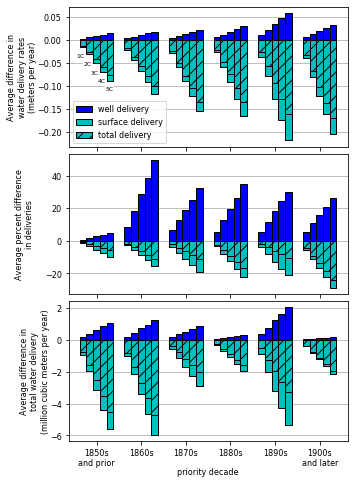

In [32]:
# Change in deliveries Mm3/yr
fs=8
fig,ax=plt.subplots(3,1,figsize=(5,8),gridspec_kw = {'wspace':0.0, 'hspace':0.05})
for i,(t,m) in enumerate(zip(['Average difference in\nwater delivery rates\n(meters per year)',
                              'Average percent difference\nin deliveries\n',
                              'Average difference in\ntotal water delivery\n(million cubic meters per year)'],[[well,sw,tot],[pwell,psw,ptot],[vwell,vsw,vtot]])):
    pd.DataFrame(m[0]).plot(kind='bar',ax=ax[i],legend=False,color='b',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[1]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',sharex=True,fontsize=fs,width=0.75)
    pd.DataFrame(m[2]).plot(kind='bar',ax=ax[i],legend=False,color='c',edgecolor='k',hatch='//',sharex=True,fontsize=fs,width=0.75)

    ax[i].grid(True,which='major',axis='y')
    ax[i].set_axisbelow(True)
    
    ax[i].set_ylabel(t,fontsize=fs,labelpad=0)

#ax[0].set_title('Difference in deliveries to water rights by decade',fontsize=fs+2)
xstart=-0.46
xinc=0.165
ystart=-0.038
yinc=0.018
for x,y,dtlab in zip([xstart+i*xinc for i in range(0,5)],[ystart-j*yinc for j in range(0,5)],['1C','2C','3C','4C','5C']):
    t=ax[0].text(x,y,dtlab,fontsize=fs-2,rotation=0,bbox=dict(boxstyle='square,pad=0',facecolor='white',edgecolor='white'))
h,l = ax[0].get_legend_handles_labels()
ax[0].legend(h[0:len(h):5],['well delivery','surface delivery','total delivery'],loc=3,fontsize=fs)
ax[i].xaxis.set_major_formatter(ticker.FixedFormatter(wrdeclab))        
plt.setp(ax[i].get_xticklabels(), rotation=0)
ax[i].set_xlabel('priority decade',fontsize=fs,labelpad=0)
fig.savefig(r'S:\CarsonValley\manuscripts\2020WR027924_final_figures\2020WR027924-f6.eps', format='eps', dpi=600,bbox_inches='tight')

In [33]:
a=[]
for i,scen in enumerate(scenlist[1:]):
    a.append(Metdf[scen]['sw_del'].sum()-Metdf[scenlist[i-1]]['sw_del'].sum())
    print(scen,Metdf[scen]['sw_del'].sum(),(Metdf[scen]['sw_del'].sum()-Metdf[scenlist[i-1]]['sw_del'].sum()))

1C 5391.345097502011 104.00241837916565
2C 5222.869422376492 -316.9471739931723
3C 5043.41684850756 -347.9282489944517
4C 4861.458762253156 -361.41066012333613
5C 4675.412069529842 -368.00477897771816
hist 5287.342679122846 425.88391686968953


In [34]:
# concat and save select means
mdf=pd.concat(mdflist,axis=1,sort=True)
hmdf=pd.concat(hmdflist,axis=1,sort=True)
hmdf['wr']=hmdf.index
hmdf['wr']=hmdf['wr'].apply(lambda x:'wr_'+x)
hmdf.set_index('wr',inplace=True)

mdf.to_csv(os.path.join(resdir,'mean_wrdf.csv'))
hmdf.to_csv(os.path.join(resdir,'mean_wrdf_Mm3y.csv'))

In [35]:
#difference in total_wr_et to explain wells mitigating SW shortfalls
# sum for each wr, divide by years
df={}
wdel={}
wet={}
tet={}
nyrs=36.22221218331232
for scen in scenlist:
    # get average annual depths
    dfsum=Metdf[scen].loc[:,['wr','well_del','wellet','total_wr_et']].groupby('wr').mean()
    dfsum['Mm2']=Metdf[scen].loc[:,['wr','Mm2']].groupby('wr').mean()
    df[scen]=dfsum[['well_del','wellet','total_wr_et']].divide(dfsum.Mm2,axis=0)
for scen in scenlist:
    # difference average annual volumes from historical average annual volumes
    wdel[scen]=(df[scen]['well_del']-df['0C']['well_del'])
    wet[scen]=(df[scen]['wellet']-df['0C']['wellet'])
    tet[scen]=(df[scen]['total_wr_et']-df['0C']['total_wr_et'])
welldel=pd.concat(wdel,axis=1)
wellet=pd.concat(wet,axis=1)
totalet=pd.concat(tet,axis=1)

['061', '067', '078', '102', '148', '255', '258', '292', '625', '628', 'monument']
153 499

0C
mean decrease in total_wr_et
pmp: 0.0, nopmp: 0.0
decrease in pmp et is nan of nopmp
nan


C:\conda3x64\envs\p3x64\lib\site-packages\pandas\core\indexing.py:947: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]



1C
mean decrease in total_wr_et
pmp: -0.014647967239749097, nopmp: -0.018506350944566485
decrease in pmp et is 0.7915102919870748 of nopmp
-22.936824268841328

2C
mean decrease in total_wr_et
pmp: -0.030887190073715654, nopmp: -0.03845404709982102
decrease in pmp et is 0.8032233900774365 of nopmp
-0.6044686336287315

3C
mean decrease in total_wr_et
pmp: -0.04782567764316074, nopmp: -0.05977135657963757
decrease in pmp et is 0.8001437541314498 of nopmp
-0.6990430557483281

4C
mean decrease in total_wr_et
pmp: -0.0656743857130504, nopmp: -0.08172150330399168
decrease in pmp et is 0.8036365345452785 of nopmp
-0.6733441885111113

5C
mean decrease in total_wr_et
pmp: -0.08403304928341522, nopmp: -0.1046959053523369
decrease in pmp et is 0.8026393104927626 of nopmp
-0.3959147047130899

hist
mean decrease in total_wr_et
pmp: 0.09742436712565503, nopmp: -0.041951149522179876
decrease in pmp et is -2.3223289048169242 of nopmp
0.3349158452880591


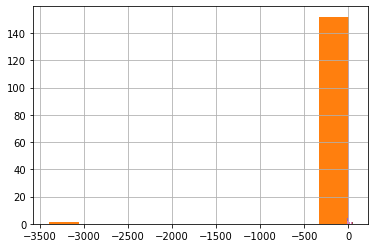

In [36]:
out=[w for w in totalet.index if totalet.loc[w,['1C','2C','3C','4C','5C']].max()>0.01] #outliers
print(out)
pmask=[w for w in wrdf.index if wrdf.loc[w,'wellnum']>0 and w not in out and 'gw' not in w]
npmask=[w for w in wrdf.index if w not in pmask and w not in out]
print(len(pmask),len(npmask))

for scen in scenlist:
    print('\n'+scen)
    df=pd.concat([wellet.loc[:,scen],totalet.loc[:,scen]],axis=1)
    df.columns=['wellet','total_wr_et']
    print('mean decrease in total_wr_et')
    print('pmp: {}, nopmp: {}'.format(df.loc[pmask,'total_wr_et'].mean(),df.loc[npmask,'total_wr_et'].mean()))
    print('decrease in pmp et is {} of nopmp'.format(df.loc[pmask,'total_wr_et'].mean()/df.loc[npmask,'total_wr_et'].mean()))
    
    
    
    p=df.loc[pmask,'wellet'].divide(df.loc[pmask,'total_wr_et'])
    print(p.loc[pmask].mean())
    p.hist()
    


In [37]:
#ratio of wellet and total_wr_et to explain wells mitigating SW shortfalls
# sum for each wr, divide by years
wdel={}
wet={}
tet={}
nyrs=36.22221218331232
  
for scen in scenlist:
    df=Metdf[scen].loc[:,['wr','well_del','wellet','total_wr_et']].groupby('wr').sum()
    wdel[scen]=df['well_del']/nyrs
    wet[scen]=df['wellet']/nyrs
    tet[scen]=df['total_wr_et']/nyrs
welldel=pd.concat(wdel,axis=1)
wellet=pd.concat(wet,axis=1)
totalet=pd.concat(tet,axis=1)

In [38]:
for scen in scenlist:
    print(scen,(totalet['0C'].sum()-totalet[scen].sum())/totalet['0C'].sum())

0C 0.0
1C 0.01723196053798322
2C 0.036640045564596775
3C 0.057009933730436356
4C 0.07924662543722101
5C 0.10227986877298366
hist -0.15352941152787047


[]
164 499
 fraction of total_wr_et from wellet
0.9799817107094235 0.16711481051978452 0.0
 fraction of total_wr_et from wellet
0.9803928793697769 0.17768838361803674 0.0
 fraction of total_wr_et from wellet
0.9807432991031877 0.1895067832856858 0.0
 fraction of total_wr_et from wellet
0.9810457049353427 0.20253750794315767 0.0
 fraction of total_wr_et from wellet
0.9813785869487531 0.21623294094175224 0.0
 fraction of total_wr_et from wellet
0.9818114453203102 0.23147984181575393 0.0
 fraction of total_wr_et from wellet
0.8681790292048778 0.06360760141376302 0.0


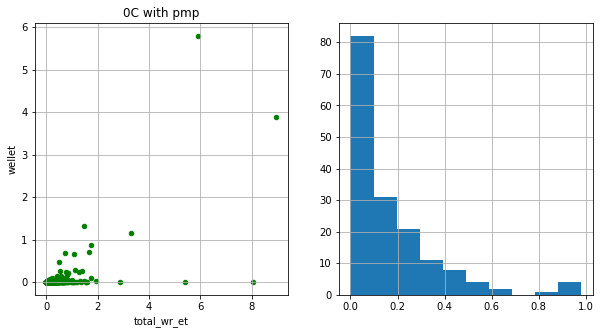

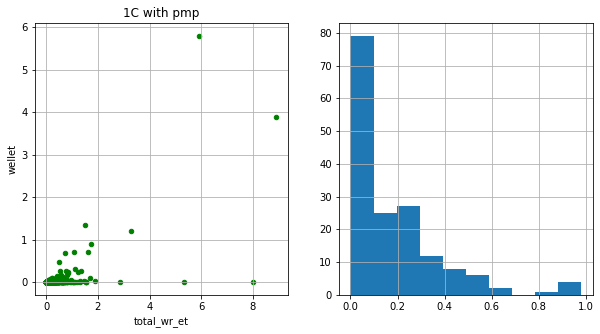

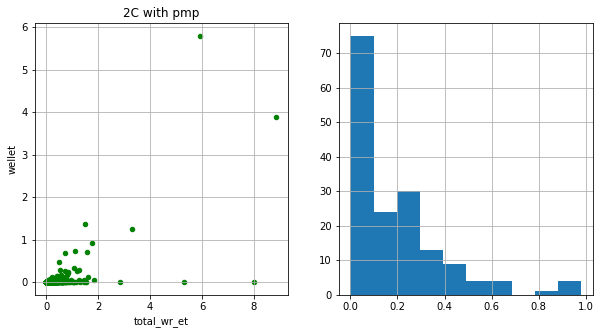

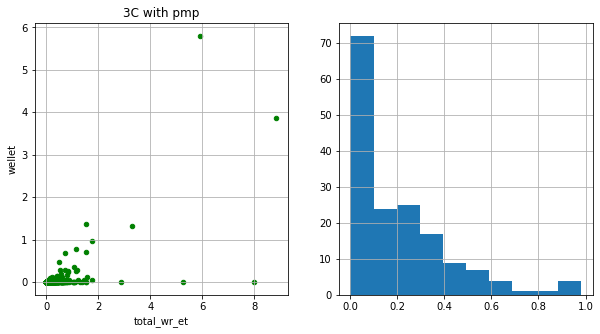

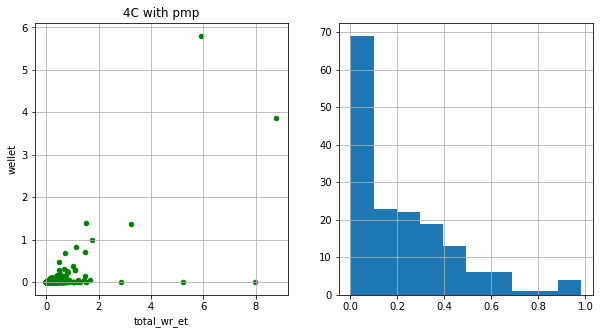

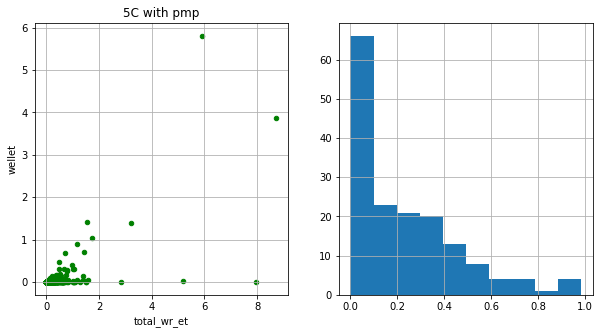

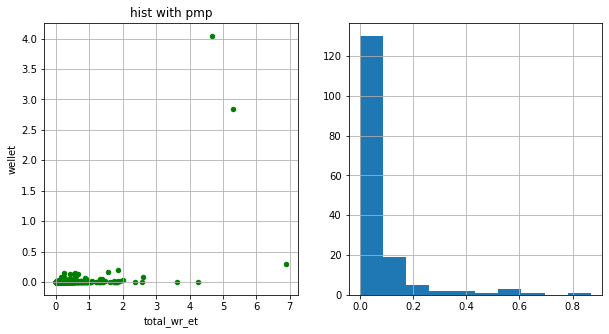

In [39]:
out=[]#[w for w in totalet.index if totalet.loc[w,['1C','2C','3C','4C','5C']].max()>300] #outliers
print(out)
pmask=[w for w in wrdf.index if wrdf.loc[w,'wellnum']>0 and w not in out and 'gw' not in w]
npmask=[w for w in wrdf.index if w not in pmask and w not in out]
print(len(pmask),len(npmask))

for scen in scenlist:
    
    fig,ax=plt.subplots(1,2,figsize=(10,5))
    df=pd.concat([wellet.loc[:,scen],totalet.loc[:,scen]],axis=1)
    df.columns=['wellet','total_wr_et']
    
    print(' fraction of total_wr_et from wellet')
    p=df.loc[pmask,'wellet'].divide(df.loc[pmask,'total_wr_et'])
    print(p.loc[pmask].max(),p.loc[pmask].mean(),p.loc[pmask].min())
    
    df.plot(x='total_wr_et',y='wellet',kind='scatter',ax=ax[0],color='g',title=scen+' with pmp',grid='on')
    p.hist(ax=ax[1])
    

In [40]:
#ET in fpy by decade
wrdec=[1,1000,1850,1860,1870,1880,1890,1900,2000]

dic={}
for i,wd in enumerate(wrdec[:-1]):
    dic[wd]={}
    for scen in scenlist:
        #mask=[o for o in etdf[scen].index]# if etdf[scen].loc[o,'wr'] not in rotwr]
        wryr=etdf[scen].groupby('wryr').mean()
        mask=[d for d in wryr.index if wrdec[i]<=d<wrdec[i+1]]
        dic[wd][scen]=wryr.loc[mask,'tot_del_fpy_scen_0C'].mean()

Text(0.5, 0, 'priority decade')

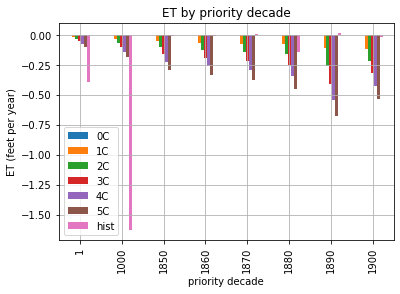

In [41]:
pd.DataFrame(dic).T.plot(kind='bar')
plt.grid()
plt.title('ET by priority decade')
plt.ylabel('ET (feet per year)')
plt.xlabel('priority decade')

In [42]:
mask=[o for o in etdf[scen].index if etdf[scen].loc[o,'wryr']<1000]
etdf['1C'].loc[mask,['tot_del_scen_0C','sw_del_scen_0C','well_del_scen_0C',
        'tot_del_fpy_scen_0C','sw_del_fpy_scen_0C','well_del_fpy_scen_0C',
        'tot_et_fpy_scen_0C','tot_et_volume_scen_0C']].head()

,tot_del_scen_0C,sw_del_scen_0C,well_del_scen_0C,tot_del_fpy_scen_0C,sw_del_fpy_scen_0C,well_del_fpy_scen_0C,tot_et_fpy_scen_0C,tot_et_volume_scen_0C
obnme,,,,,,,,
et_dcsid02_80,1.900e-06,0.000e+00,1.900e-06,2.138e-12,0.000e+00,2.138e-12,-2.001e-01,-1.779e+05
et_dcsid03_80,-5.468e+02,0.000e+00,-5.468e+02,-2.082e-05,0.000e+00,-2.082e-05,-6.642e-03,-1.745e+05
et_dcsid05_80,-2.000e-09,0.000e+00,-2.000e-09,-1.292e-14,0.000e+00,-1.292e-14,3.183e-04,4.925e+01
et_dcsid06_80,-5.972e+04,-5.972e+04,0.000e+00,-4.500e-04,-4.500e-04,0.000e+00,-2.202e-03,-2.922e+05
et_dvn_80,-1.471e+06,-1.471e+06,0.000e+00,-2.312e-01,-2.312e-01,0.000e+00,-1.640e-01,-1.044e+06


# precip

In [43]:
# finf files are precip in 1/1000th of a foot and some sp's are missing
for scen in scenlist:
    arr=[]
    modir=os.path.join('..\\..\\','model','external_files','Carson_Valley','arrays','uzf')
    for f in os.listdir(modir):
        if f.endswith('.finf'): #list of all sp finf
            arr.append(np.loadtxt(os.path.join(modir,f)).sum())

In [44]:
nsp=1891
finffact=np.mean([1.6689684211000E-4,1.0987977895000E-4]) #*precip = what goes in

In [45]:
#arr is list of total model wide precip for each stress period in 1/1000th of fpd
mean_sp_vol=np.sum(arr)*550*550/(3.28**3)/1000000/nsp #in 1000th of Mm3 per day
mean_ann_vol=mean_sp_vol/1000*365
#finffact * precip = into ground
#ET + into ground = precip
# ET = precip (1 - finfact)
mean_ann_pcpet = mean_ann_vol * (1-finffact*1000)

In [46]:
mean_ann_vol

210.8584716215805

In [47]:
mean_ann_pcpet

181.678123972932

# ssf flow

In [49]:
for scen in scenlist:
    ssf=[]
    modir=os.path.join('..\\..\\','model','MSGSF_'+scen,'Carson_Valley')
    for fname in os.listdir(os.path.join(modir,'pmptabs')):
        count=0
        if len(fname.split('-'))>4 and fname.split('-')[3]=='ssf': #should be 2 line file w [day ssf]
            site=fname.split('-')[4]
            with open (os.path.join(modir,'pmptabs',fname),'r') as f:
                val=float(f.readline().strip().split()[1])
            with open (os.path.join(modir,'CV-wes-8015trans.wel'),'r') as f:
                wellines=f.readlines()
            for line in wellines:
                if site in line:
                    count=count+1
            print(site,count)
            ssf.append(val*count)

bodieflatq 78
clearcreeq 21
daggettcaq 13
eaglevallq 7
eastforkcq 42
frederickq 24
indiancreq 33
jacksvallq 23
jobscanyoq 23
larsoncanq 39
luthercanq 23
millberryq 123
mottsvillq 39
oldclearcq 14
sierracanq 80
bodieflatq 78
clearcreeq 21
daggettcaq 13
eaglevallq 7
eastforkcq 42
frederickq 24
indiancreq 33
jacksvallq 23
jobscanyoq 23
larsoncanq 39
luthercanq 23
millberryq 123
mottsvillq 39
oldclearcq 14
sierracanq 80
bodieflatq 78
clearcreeq 21
daggettcaq 13
eaglevallq 7
eastforkcq 42
frederickq 24
indiancreq 33
jacksvallq 23
jobscanyoq 23
larsoncanq 39
luthercanq 23
millberryq 123
mottsvillq 39
oldclearcq 14
sierracanq 80
bodieflatq 78
clearcreeq 21
daggettcaq 13
eaglevallq 7
eastforkcq 42
frederickq 24
indiancreq 33
jacksvallq 23
jobscanyoq 23
larsoncanq 39
luthercanq 23
millberryq 123
mottsvillq 39
oldclearcq 14
sierracanq 80
bodieflatq 78
clearcreeq 21
daggettcaq 13
eaglevallq 7
eastforkcq 42
frederickq 24
indiancreq 33
jacksvallq 23
jobscanyoq 23
larsoncanq 39
luthercanq 23
millber

In [50]:
tot_ssf=np.sum(ssf)*365/(3.28**3)/1000000
tot_ssf

16.24657965023226

# Now do wells

In [74]:
# get well areas
welltable=os.path.join(extdir,'CV_PMP_POU_area.csv')
wellarea=pd.read_csv(welltable, dtype={'app': 'object'})
wellarea.app='pmp_'+wellarea.app.str.rjust(5,'0')
wellarea.set_index(wellarea.app,inplace=True)
wellarea.drop('app',inplace=True,axis=1)


In [75]:
welldf={}
outdir=r'S:\kitlasten2020_wrr\output'
scenlist,scens=get_scens()
    
#get well deliveries from post-processor
for scen in scenlist:
    if not os.path.exists(os.path.join(outdir,scen)):
        os.mkdir(os.path.join(outdir,scen))
    df=pd.read_csv(os.path.join(scens[scen],'sim_pmp_ts.txt'),delim_whitespace=True,index_col=False)
    d8str=df.loc[:,'obnme'].str.split('_').str.get(-1)+'0101'
    df['yr']=pd.to_datetime(d8str,format='%y%m%d')
    df['well']='pmp_'+df.loc[:,'obnme'].str.split('_',1).str.get(0)
    welldf[scen]=df.copy(deep=True)


In [76]:
# group and write
mdflist=[]
whmdflist=[]
for scen in scenlist:
    print(scen)
    if 'MAR' in scen:
        #base scenario... ie no mar
        bscen=scen.replace('MAR','')
        
        welldf[scen].index=welldf[scen].obnme
        welldf[bscen].index=welldf[bscen].obnme
        welldf[scen]['wypmp_mar_nomar']=welldf[scen]['wypmp']-welldf[bscen]['wypmp']
        
        mdf=welldf[scen].loc[:,['well','wypmp','wypmp_scen_0C']].groupby('well').mean() #well becomes index, don't include in cols
        mdf.columns=['dT'+scen+'_'+c for c in mdf.columns]
        mdflist.append(mdf) #well becomes index, don't include in cols
        
        # convert wrpmp to Mm3
        whmdf=mdf.divide((3.28084**3)*1.0e6)
        whmdf['area']= wellarea['Shape_Area_m2']
        whmdf['dT'+scen+'_wypmp_mpy_mar_nomar']=mdf['dT'+scen+'_wypmp_mar_nomar'].divide(whmdf['area'])
        whmdflist.append(whmdf)
    if 'MAR' not in scen:
        #base scenario... ie 0C
        bscen='0C'
        
        welldf[scen].index=welldf[scen].obnme
        welldf[bscen].index=welldf[bscen].obnme
        welldf[scen]['wypmp_scen_0C']=welldf[scen]['wypmp']-welldf[bscen]['wypmp']
        
        mdf=welldf[scen].loc[:,['well','wypmp','wypmp_scen_0C']].groupby('well').mean() #well becomes index, don't include in cols
        mdf.columns=['dT'+scen+'_'+c for c in mdf.columns]
        mdflist.append(mdf)
        
        # convert wrpmp to Mm3
        whmdf=mdf.divide((3.28084**3)*1.0e6)
        whmdf['area']= wellarea['Shape_Area_m2']
        whmdf['dT'+scen+'_wypmp_mpy_scen_0C']=mdf['dT'+scen+'_wypmp_scen_0C'].divide(whmdf['area'])
        whmdflist.append(whmdf)
        


0C
1C
2C
3C
4C
5C
hist


In [77]:
# concat and save means
mdf=pd.concat(mdflist,axis=1,sort=True)
whmdf=pd.concat(whmdflist,axis=1,sort=True)

mdf.to_csv(os.path.join(outdir,'mean_welldf.csv'))
whmdf.to_csv(os.path.join(outdir,'mean_welldf_Mm3y.csv'))

In [83]:
whmdf.index

Index(['pmp_07862', 'pmp_08494', 'pmp_08771', 'pmp_09244', 'pmp_11853',
       'pmp_12026', 'pmp_12532', 'pmp_13896', 'pmp_14565', 'pmp_15388',
       ...
       'pmp_83900', 'pmp_84232', 'pmp_84860t', 'pmp_84862t', 'pmp_85189t',
       'pmp_85285t', 'pmp_v02881', 'pmp_v05080', 'pmp_v09062', 'pmp_wypmp'],
      dtype='object', name='well', length=208)

In [81]:
mask=[c for c in whmdf.columns if 'dT' in c and 'scen' not in c and 'area' not in c]
mi=[i for i in whmdf.index if 'pmp_wypmp' not in i]
whmdf.loc[mi,mask].sum()

dT0C_wypmp      38.297
dT1C_wypmp      39.335
dT2C_wypmp      40.488
dT3C_wypmp      41.699
dT4C_wypmp      42.869
dT5C_wypmp      44.108
dThist_wypmp    18.589
dtype: float64

In [58]:
#effluent flows
for scen in scenlist:
    amf=[]
    momf=[] #monthly mean flow
    names=[]
    datadir=os.path.join('..\\..\\','model','MSGSF_'+scen,'tabfiles_'+scen)
    for f in os.listdir(datadir):
        if 'effluent' in f and 'DCSIDE' not in f and 'DCSIDW' not in f:
            site=f.split('-')[2]
            df=pd.read_csv(os.path.join(datadir,f),names=['day','flow'],usecols=[0,1],delim_whitespace=True)
            df['simstart']=pd.to_datetime(simstart)
            df['datetime']=df['simstart']+pd.to_timedelta(df['day'],unit='days')
            df.index=df.datetime
            df.drop_duplicates(inplace=True)
            df=df.resample('D').bfill()

            df['month']=df.index.month
            df['year']=df.index.year

            mo=df.loc[scend8s,['flow','month']].groupby('month').mean()# mean monthly value in cfd
            ann=df.loc[scend8s,['flow','year']].groupby('year').sum()#summed to give annual total
            momf.append(mo)
            amf.append(ann.loc[scenyrs,:])
            names.append(site)
    maf=pd.concat(amf,axis=1)
    maf.columns=names
    mmof=pd.concat(momf,axis=1)
    mmof.columns=names

    totmaf=maf.loc[scenyrs,names].sum(axis=1).mean()
    totmmof=mmof.loc[irrmo].sum().sum()*30
    print(scen,totmaf*cft2Mm3,totmmof*cft2Mm3)

0C 18.73671124069695 18.93862106736094
1C 18.73671124069695 18.93862106736094
2C 18.73671124069695 18.93862106736094
3C 18.73671124069695 18.93862106736094
4C 18.73671124069695 18.93862106736094
5C 18.73671124069695 18.93862106736094
hist 12.416728028561442 12.063165510091236


In [62]:
maf.sum(axis=1).mean()*cft2Mm3

12.416728028561442

# Surface water analysis - baseline (w PRMS and without)
Accretion/depletion (outflow-(EF+WF))

Cummulative measured and simulated
    
    A couple sites throughout the basin, but not enough continuous record at any given site 

Average monthly outflows

# historical data inflows

In [87]:
# read stream gage files

# record based inflows are flawed due to lack of regression, use Maurer



datadir=r'S:\CarsonValley\flows\carsonstreamflow\in'
gage={}
insite=[]
for fname in os.listdir(datadir):
    if 'ipynb' not in fname:
        print(fname)
        skip=0
        site=fname.split()[0]
        insite.append(site)
        with open(os.path.join(datadir,fname),'r') as f:
            lines=f.readlines()
        for i,line in enumerate(lines[:100]):
            data=line.strip().split()
            if 'agency_cd' == data[0]:
                header=data
                for j,h in enumerate(header):
                    if h in ['02_00060_00003','discharge_va','04_00060_00003','01_00060_00003']:
                        header[j]='flow'
                    if h in ['measurement_dt']:
                        header[j]='datetime'
                if 'flow' not in header:                        
                    print('no flow key in {}'.format(site))
            if 'USGS' == data[0] and site == data[1] and skip==0:
                skip=i
        gage[site]=pd.read_csv(os.path.join(datadir,fname),skiprows=skip,names=header,sep='\t',comment='_')
        gage[site]['flow']=gage[site]['flow']*86400 #to cfd
        gage[site]['datetime']=pd.to_datetime(gage[site]['datetime'])
        gage[site] = gage[site].set_index(pd.DatetimeIndex(gage[site]['datetime']))

10309000 E FK CARSON RV NR GARDNERVILLE, NV.txt
10309025 INDIAN CK AT WOODFORDS, CA.txt
10310000 W FK CARSON RV AT WOODFORDS, CA.txt
10310300 FREDERICKSBURG CYN CK NR FREDERICKSBURG, CA.txt
10310330 LUTHER CK NR FREDRICKSBURG, CA.txt
10310350 MILLER SPGS NR SHERIDAN, NV.txt
10310360 JOBS CYN CK NR MINDEN, NV.txt
10310370 SHERIDAN CK NR MINDEN, NV.txt
10310375 STUTLER CYN CK NR MINDEN, NV.txt
10310380 MONUMENT CK NR MINDEN, NV.txt
10310385 MOTT CYN CK NR MINDEN, NV.txt
10310400 DAGGETT CK NR GENOA, NV.txt
10310410 GENOA CYN CK AT GENOA, NV.txt
10310415 SIERRA CYN CK NR GENOA, NV.txt
10310425 JAMES CYN CK NR GENOA, NV.txt
10310430 WATER CYN NR GENOA, NV.txt
10310500 CLEAR CK NR CARSON CITY, NV.txt


In [88]:
gage['efwf']=pd.DataFrame(gage['10309000'].loc[:,'flow']+gage['10310000'].loc[:,'flow'])
gage['efwf']['month']=gage['efwf'].index.month
gage['efwf']['year']=gage['efwf'].index.year

# historical data outflows

In [136]:
header=[]
# read outflow gage
datadir=r'S:\CarsonValley\flows\carsonstreamflow\obs\DATA'
for fname in os.listdir(datadir):
    if '10311000' == fname.split()[0]:
        skip=0
        site=fname.split()[0]
        with open(os.path.join(datadir,fname),'r') as f:
            lines=f.readlines()
        for i,line in enumerate(lines[:100]):
            data=line.strip().split()
            if 'agency_cd' == data[0]:
                header=data
                for j,h in enumerate(header):
                    if h in ['02_00060_00003','discharge_va','04_00060_00003','01_00060_00003']:
                        header[j]='flow'
                if 'flow' not in header:
                    print('no flow key in {}'.format(site))
            if 'USGS' == data[0] and site == data[1] and skip==0:
                skip=i
        gage[site]=pd.read_csv(os.path.join(datadir,fname),skiprows=skip,names=header,sep='\t',comment='_')
        gage[site]['flow']=gage[site]['flow']*86400 #to cfd
        gage[site]['datetime']=pd.to_datetime(gage[site]['datetime'])
        gage[site] = gage[site].set_index(pd.DatetimeIndex(gage[site]['datetime']))
        gage[site]=gage[site].resample('D').interpolate(method='linear')

In [137]:
for site in gage:
    gage[site]['month']=gage[site].index.month
    gage[site]['year']=gage[site].index.year

In [138]:
#aggregate flows to get mean annual inflows, sum of all sites
amf=[]
momf=[] #monthly mean flow
names=[]
for site in ['10311000']:
    df=gage[site].copy()
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index(pd.DatetimeIndex(df['datetime']))
    oidx = df.index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq='D')
    rdf=df.reindex(nidx, method='nearest', limit=30).interpolate()#limit interp to 30 days
    rdf['month']=rdf.index.month
    rdf['year']=rdf.index.year
    
    mo=rdf.loc[scend8s,['flow','month']].groupby('month').mean()# mean monthly value in cfd
    ann=rdf.loc[scend8s,['flow','year']].groupby('year').sum()#summed to give annual total
    momf.append(mo)
    amf.append(ann.loc[scenyrs,:])
    names.append(site)
    maf=pd.concat(amf,axis=1)
    maf.columns=names
    mmof=pd.concat(momf,axis=1)
    mmof.columns=names

    totmaf=maf.loc[scenyrs,names].sum(axis=1).mean()
    totmmof=mmof.loc[irrmo].sum().sum()*30
    print('mean historical annual outflows: {}'.format(totmaf*cft2Mm3))
    print('mean historical irrigation season outlows: {}'.format(totmmof*cft2Mm3))

mean historical annual outflows: 332.50541678175784
mean historical irrigation season outlows: 212.9402858395811


In [139]:
gage['10311000'].loc[scend8s,['year','flow']].groupby('year').sum().mean()*cft2Mm3

flow    332.505
dtype: float64

In [101]:
#aggregate flows to get mean annual outflows
amf=[]
momf=[] #monthly mean flow
names=[]
for site in ['10311000']:
    df=gage[site].copy()
    if 'datetime' in df.columns:
        df['datetime'] = pd.to_datetime(df['datetime'])
        df = df.set_index(pd.DatetimeIndex(df['datetime']))
    oidx = df.index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq='D')
    rdf=df.reindex(nidx, method='nearest', limit=30).interpolate()#limit interp to 30 days
    rdf['month']=rdf.index.month
    rdf['year']=rdf.index.year
    
    mo=rdf.loc[scend8s,['flow','month']].groupby('month').mean()# mean monthly value in cfd
    ann=rdf.loc[scend8s,['flow','year']].groupby('year').sum()#summed to give annual total
    momf.append(mo)
    amf.append(ann.loc[scenyrs,:])
    names.append(site)
    maf=pd.concat(amf,axis=1)
    maf.columns=names
    mmof=pd.concat(momf,axis=1)
    mmof.columns=names

    totmaf=maf.loc[scenyrs,names].sum(axis=1).mean()
    totmmof=mmof.loc[irrmo].sum().sum()*30
    print('mean historical annual outflows: {}'.format(totmaf*cft2Mm3))
    print('mean historical irrigation season outlows: {}'.format(totmmof*cft2Mm3))

mean historical annual outflows: 332.50541678175784
mean historical irrigation season outlows: 212.9402858395811


## the following is useless due to missing records, unless linear regression was used, but that sucks anyway
#aggregate flows to get mean annual flows for each site
#can't use simulation period (scend8s) due to missing records, fill with mean values, then sample over scenyrs
amf=[]
momf=[] #monthly mean flow
names=[]
for site in gage.keys():
    df=gage[site].copy()
    df = df.set_index(pd.DatetimeIndex(df['datetime']))
    oidx = df.index
    nidx = pd.date_range(oidx.min(), oidx.max(), freq='D')
    rdf=df.reindex(nidx, method='nearest', limit=2)
    rdf.interpolate(method='time',inplace=True)
    rdf.index=pd.DatetimeIndex(rdf.index.date)
    rdf.fillna(value=rdf.loc[scend8s,'flow'].mean())
    rdf['month']=rdf.index.month
    rdf['year']=rdf.index.year   
    
    mo=rdf.loc[scend8s,['flow','month']].groupby('month').mean()# mean monthly value in cfd
    ann=rdf.loc[scend8s,['flow','year']].groupby('year').sum()#summed to give annual total
    momf.append(mo)
    amf.append(ann)
    names.append(site)
maf=pd.concat(amf,axis=1)
maf.columns=names
mmof=pd.concat(momf,axis=1)
mmof.columns=names

totmaf=maf.loc[scenyrs,names].sum(axis=1).mean()
totmmof=mmof.loc[irrmo].sum().sum()*30
print('mean historical annual inflows {}'.format(totmaf*cft2Mm3))
print('mean historical irrigation season inflows {}'.format(totmmof*cft2Mm3))

# simulation inflows

In [102]:
def inflow_tabfiles():
    # read stream intab files
    sdf={}
    for scen in scenlist:
        dflist=[]
        names=[]
        datadir=os.path.join('..\\..\\','model','MSGSF_'+scen,'tabfiles_'+scen)
        for fname in os.listdir(datadir):
            site=fname.split('-')[3][0:8]
            if site in insite:
                df=pd.read_csv(os.path.join(datadir,fname),names=['day','flow'],delim_whitespace=True)
                df['simstart']=pd.to_datetime(simstart)
                df['datetime']=df['simstart']+pd.to_timedelta(df['day'],unit='days')
                df.index=df.datetime
                df=df.resample('D').bfill()
                dflist.append(df.loc[:,['flow']])
                names.append(site)
        sdf[scen]=pd.concat(dflist,axis=1)
        sdf[scen].columns=names
        sdf[scen]['month']=sdf[scen].index.month
        sdf[scen]['year']=sdf[scen].index.year
    return(sdf)

In [103]:
inflow=inflow_tabfiles()

In [104]:
for s in ['hist','0C','1C','2C','3C','4C','5C']:
    ef=pd.DataFrame(inflow[s].loc[:,'10309000'].copy())
    ef['month']=ef.index.month
    mask=[i for i in ef.index if ef.loc[i,'10309000']>200*86400 and ef.loc[i,'month'] in irrmo]
    print(s,len(mask))

hist 3614
0C 3614
1C 3481
2C 3312
3C 3143
4C 2960
5C 2794


In [105]:
#simulated inflows
incols=[c for c in inflow[scen].columns if c not in ['month','year','datetime','inflow']]
for scen in ['hist','0C','1C','2C','3C','4C','5C']:
    ann=inflow[scen].loc[scend8s,['inflow','year']].groupby('year').sum().mean().mean()*cft2Mm3
    print(scen,ann)

hist 0.0
0C 0.0
1C 0.0
2C 0.0
3C 0.0
4C 0.0
5C 0.0


C:\conda3x64\envs\p3x64\lib\site-packages\pandas\core\indexing.py:1404: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [106]:
for scen in inflow:
    inflow[scen]['inflow']=inflow[scen].loc[:,incols].sum(axis=1)

In [107]:
#simulated irrigation season inflows
incols=[c for c in inflow[scen].columns if c not in ['month','year','datetime','inflow']]
for scen in ['hist','0C','1C','2C','3C','4C','5C']:
    mo=inflow[scen].loc[scend8s,['inflow','month']].groupby('month').mean()*cft2Mm3*30.5
    imo=mo.loc[irrmo].sum().sum()
    print(scen,imo)

hist 356.78993760714707
0C 356.78993760714707
1C 341.0995970456593
2C 324.1210530715378
3C 305.843213055383
4C 286.3877381617557
5C 265.93874911826776


# simulation outflows

In [143]:
def outflow_sgag():
    # read stream gage files for outflow
    sdf={}
    for scen in scenlist:
        dflist=[]
        names=[]
        datadir=os.path.join('..\\..\\','output','output_MSGSF_'+scen)
        for fname in os.listdir(datadir):
            if '10311000.sgag' in fname:
                site=fname.split('-')[3].replace('.sgag','')
                df=pd.read_csv(os.path.join(datadir,fname),usecols=[0,2],skiprows=3,names=['day','flow'],delim_whitespace=True)
                df['simstart']=pd.to_datetime(simstart)
                df['datetime']=df['simstart']+pd.to_timedelta(df['day'],unit='days')
                df.index=df.datetime
                df=df.resample('D').bfill().ffill()
                dflist.append(df)
                names.append(site)
        sdf[scen]=pd.concat(dflist,axis=1,names=names)
        sdf[scen]['month']=sdf[scen].index.month
        sdf[scen]['year']=sdf[scen].index.year
    return(sdf)
                

In [144]:
outflow=outflow_sgag()

In [146]:
scend8s.difference(outflow['0C'].index)

DatetimeIndex(['2015-09-29', '2015-09-30'], dtype='datetime64[ns]', freq=None)

In [147]:
#annual outflow
for scen in ['hist','0C','1C','2C','3C','4C','5C']:
    ann=outflow[scen].loc[scend8s,['year','flow']].groupby('year').sum().mean()['flow']*cft2Mm3
    print(scen,ann)

hist 287.6236802633177
0C 292.9551553617122
1C 293.1219660572699
2C 294.94025988106137
3C 298.15190927293173
4C 302.3599818979667
5C 307.27884954598255


In [119]:
#irrigation season outflow
for scen in ['hist','0C','1C','2C','3C','4C','5C']:
    mo=outflow[scen].loc[scend8s,['month','flow']].groupby('month').sum()*cft2Mm3/30.5
    imo=mo.loc[irrmo].sum()['flow']
    print(scen,imo)

hist 253.01071865124518
0C 255.28406013378037
1C 241.87389984378342
2C 227.54501900291027
3C 212.0964776763119
4C 195.5086641536576
5C 177.96633157824147


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


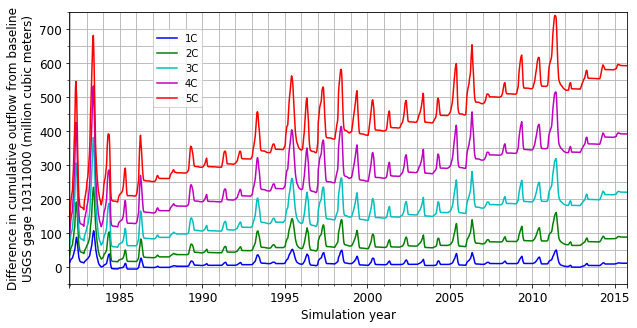

In [120]:
leg=['1C','2C','3C','4C','5C']
colors=['b','g','c','m','r']
fig,ax=plt.subplots(1,1,figsize=figsize)
for s,c in zip(leg,colors):
    d=(outflow[s].loc[:,'flow']-outflow['0C'].loc[:,'flow'])*cft2Mm3
    d.cumsum().plot(ax=ax,color=c)
ytick = range(-50,800,100)
ax.set_ylim(0,700)
ax.set_xlim(datetime.date(1981,12,1),datetime.date(2015,9,30))
ax.set_yticks(ytick, minor=True )
ax.grid('on', which='both', axis='both' )
ax.tick_params(labelsize=12)
ax.set_axisbelow(True)
ax.legend(leg,loc=(0.15,0.65))
ax.set_xlabel('Simulation year',fontsize=12)
ax.set_ylabel('Difference in cumulative outflow from baseline\nUSGS gage 10311000 (million cubic meters)',fontsize=12)
plt.savefig(r'S:\CarsonValley\manuscripts\2020WR027924_final_figures\2020WR027924-f12.eps', format='eps')

10.56672032755034
87.43196769003193
219.56157799904958
391.0212970817569
591.9588517616093


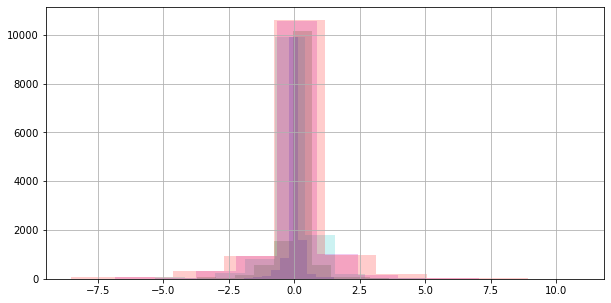

In [121]:
leg=['1C','2C','3C','4C','5C']
colors=['b','g','c','m','r']
fig,ax=plt.subplots(1,1,figsize=figsize)
for s,c in zip(leg,colors):
    d=(outflow[s].loc[:,'flow']-outflow['0C'].loc[:,'flow'])*cft2Mm3
    d.hist(ax=ax,color=c,alpha=0.2)
    print(d.sum())

In [125]:
# calculate monthly mean dif
mlst=[]
for scen in ['1C','2C','3C','4C','5C']:
    mlst.append((outflow[scen].loc[:,['flow','month']].groupby('month').mean()-outflow['0C'].loc[:,['flow','month']].groupby('month').mean())*cft2Mm3*30)

modif=pd.concat(mlst,axis=1)
modif.columns=['1C','2C','3C','4C','5C']

In [126]:
modif

,1C,2C,3C,4C,5C
month,,,,,
1,1.988,4.470,7.487,11.085,15.263
2,2.808,6.248,10.345,15.017,20.276
3,6.920,14.804,23.521,32.775,42.070
4,7.165,14.272,20.475,25.033,27.568
5,-2.400,-6.659,-12.657,-20.118,-28.620
6,-9.905,-19.922,-29.531,-38.265,-45.801
7,-4.652,-8.677,-11.965,-14.480,-16.343
8,-1.426,-2.508,-3.295,-3.873,-4.308
9,-0.691,-1.177,-1.524,-1.737,-1.856


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


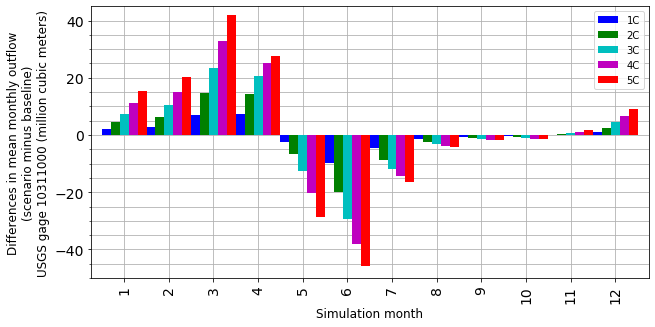

In [127]:
leg=['1C','2C','3C','4C','5C']
colors=['b','g','c','m','r']
fig,ax=plt.subplots(1,1,figsize=figsize)
modif.plot(kind='bar',width=1,ax=ax,figsize=figsize,color=colors)
ax.set_xlabel('Simulation month',fontsize=12)
ax.set_ylabel('Differences in mean monthly outflow\n(scenario minus baseline)\nUSGS gage 10311000 (million cubic meters)',fontsize=12)
ytick = range(-50,45,5)
ax.set_ylim(-45,45)
ax.set_yticks(ytick, minor=True )
ax.grid('on', which='both', axis='both' )
ax.tick_params(labelsize=14)
ax.set_axisbelow(True)
ax.legend(leg)
plt.savefig(r'S:\CarsonValley\manuscripts\2020WR027924_final_figures\2020WR027924-f13.eps', format='eps')

In [546]:
modif

,1C,2C,3C,4C,5C
month,,,,,
1,1.988,4.470,7.487,11.085,15.263
2,2.808,6.248,10.345,15.017,20.276
3,6.920,14.804,23.521,32.775,42.070
4,7.165,14.272,20.475,25.033,27.568
5,-2.400,-6.659,-12.657,-20.118,-28.620
6,-9.905,-19.922,-29.531,-38.265,-45.801
7,-4.652,-8.677,-11.965,-14.480,-16.343
8,-1.426,-2.508,-3.295,-3.873,-4.308
9,-0.691,-1.177,-1.524,-1.737,-1.856


In [212]:
lst=[]
for g in ['10309000','10310000','10311000']:
    lst.append(gage[g].loc[scend8s,'flow'])
df=pd.concat(lst,axis=1)
df.fillna(method='ffill',inplace=True)
df.columns=['10309000','10310000','10311000']
df.to_csv('Carson Valley gage data.csv')

In [213]:
lst=[]
for g in ['10311000']:
    lst.append(outflow['hist'].loc[scend8s,'flow'])
df=pd.concat(lst,axis=1)
df.columns=['10311000']
df.fillna(method='ffill',inplace=True)
df.to_csv('Carson Valley simulated outflow.csv')

# Validation

In [221]:
# Eric did the fit stats for streamflow, NSE is wrong here, skip to heads

In [239]:
#outflow validation
# average over period, then difference
for p in ['month','year']:
    sf=outflow['hist'].loc[scend8s,['flow',p]].groupby(p).mean()
    gf=gage['10311000'].loc[scend8s,['flow',p]].groupby(p).mean()
    rmse=(((sf-gf)**2).mean()**0.5)*cft2Mm3
    
    nse=1-((sf-gf).values**2).sum()/((gf.loc[:,'flow']-gf.loc[:,'flow'].mean())**2).sum()
    
    print(p+'/nrmse nse bias')
    print('{}'.format(rmse['flow']))
    print('{}'.format(nse))
    print('{}'.format((outflow['hist'].loc[scend8s,['flow',p]]-gage['10311000'].loc[scend8s,['flow',p]]).mean()*cft2Mm3))

month/nrmse nse bias
0.26431045849301
0.8774484016575634
flow    -0.126416
month    0.000000
dtype: float64
year/nrmse nse bias
0.22371207614535826
0.9014861165785304
flow   -0.126416
year    0.000000
dtype: float64


In [240]:
# outflow validation
#average over period, then difference
rlist=[]
nlist=[]

for m in range(1,13):
    #sf simulated total monthly flow
    
    pout=outflow['hist'].loc[scend8s,['flow','month','year']]
    sf=pout.loc[pout['month']==m,['flow','year']].groupby('year').mean()
    pgag=gage['10311000'].loc[scend8s,['month','flow','year']]
    gf=pgag.loc[pgag['month']==m,['flow','year']].groupby('year').mean()
    rmse=(((sf-gf)**2).mean()**0.5)*cft2Mm3

    nse=1-((sf-gf).values**2).sum()/((gf.loc[:,'flow']-gf.loc[:,'flow'].mean())**2).sum()

    rlist.append(rmse['flow'])
    nlist.append(nse)
print('rmse')
for r in rlist:
    print(r)
print('nse')
for n in nlist:
    print(n)

rmse
1.1056003850525213
0.9295425735368142
0.49368750222815827
0.9183499134057778
1.1620007092995852
0.9920782948170254
0.37493647109117245
0.3497767578120145
0.16747892984688742
0.2046036014381479
0.3440296783051961
0.48816061689421286
nse
0.27009607346953557
0.023566429485180174
0.656517910382782
-0.025471278347016568
0.6160875388788132
0.8208327353883188
0.8811643820731557
-0.46605634070588686
-0.15025866242357688
0.4091562524712775
0.4093296430360043
0.10532062350349736


In [270]:
# EFWF validation
#average over period, then difference
inflow['hist']['year']=inflow['hist'].index.year
inflow['hist']['month']=inflow['hist'].index.month
for s in ['10310000','10309000']:
    print(s)
    rlist=[]
    nlist=[]
    print(gage[s].groupby('year').sum().mean()*cft2Mm3)
    for m in range(1,13):
        #sf simulated total monthly flow
        pinf=inflow['hist'].loc[scend8s,[s,'month','year']]
        sf=pinf.loc[pinf['month']==m,[s,'year']].groupby('year').mean()
        sf.columns=['flow']
        gf=gage[s].loc[gage[s]['month']==m,['flow','year']].groupby('year').mean()
        rmse=(((sf-gf)**2).mean()**0.5)*cft2Mm3

        nse=1-((sf-gf).values**2).sum()/((gf.loc[:,'flow']-gf.loc[:,'flow'].mean())**2).sum()

        rlist.append(rmse['flow'])
        nlist.append(nse)
    print('rmse')
    for r in rlist:
        print(r)
    print('nse')
    for n in nlist:
        print(n)

10310000
site_no    103.641064
flow        86.798763
month        0.000066
dtype: float64
rmse
0.1707853308387202
0.07269900277345763
0.0754747267776505
0.15538659509322397
0.26717337644933575
0.210833623141715
0.10918531116002793
0.060247308987199016
0.04498962627935852
0.03226441686144265
0.03602838355410695
0.0456764588560103
nse
0.5117915604032196
0.4053077466801107
0.6376412870661536
0.39513345730231353
0.6795820376996091
0.8404873149710826
0.8206262126467925
0.5804048057907072
0.19194892245613826
0.1362623409039413
0.771700431205298
0.7405685170837173
10309000
site_no    103.631012
flow       305.299978
month        0.000066
dtype: float64
rmse
0.5580272269491549
0.4443449871164933
0.4789505525657224
0.8512262380523407
1.0402575202373985
0.7835238176633369
0.2518056278861164
0.3138178468025673
0.18565567839639846
0.13827079019938274
0.20080552064238585
0.3196654247345606
nse
0.3748840675964179
0.1460037135440586
0.0482322441921621
-1.3390211804574794
0.43280787206579363
0.8021985

In [242]:
# EFWF validation
#average over period, then difference
inflow['hist']['year']=inflow['hist'].index.year
inflow['hist']['month']=inflow['hist'].index.month
for s in ['10310000','10309000']:
    print(s)
    for p in ['month','year']:
        sf=inflow['hist'].loc[scend8s,[s,p]].groupby(p).mean()
        sf.columns=['flow']
        gf=gage[s].loc[scend8s,['flow',p]].groupby(p).mean()
        rmse=(((sf-gf)**2).mean()**0.5)*cft2Mm3

        nse=1-((sf-gf).values**2).sum()/((gf.loc[:,'flow']-gf.loc[:,'flow'].mean())**2).sum()

        print(p+' rmse nse')
        print('{}'.format(rmse['flow']))
        print('{}'.format(nse))

10310000
month rmse nse
0.04085763787456442
0.9689681652320422
year rmse nse
0.03304192535162919
0.94554721971461
10309000
month rmse nse
0.19688508703570987
0.9372778493434925
year rmse nse
0.15709182498906382
0.8985052187629164


In [259]:
#old
d=outflow['hist'].loc[scend8s,'flow']-gage['10311000'].loc[scend8s,'flow']
d.dropna(inplace=True)
#stats
rmse=(((d.values)**2).mean())**0.5
gmean=gage['10311000'].loc[scend8s,'flow'].mean()
q25=gage['10311000'].loc[scend8s,'flow'].quantile(q=0.25)
q75=gage['10311000'].loc[scend8s,'flow'].quantile(q=0.75)

print('35-year simulation period statistics')
print('Mean measured flow Mm3/yr: {}'.format(gmean*cft2Mm3*365.25))
print('Mean measured flow ac-ft/yr: {}'.format(gmean*365.25/43560))

print('RMSE (Mm3/yr): {}'.format(rmse*cft2Mm3*365.25))
print('RMSE (ac-ft/yr):{}'.format(rmse*365.25/43560))

print('nRMSE (mean): {}'.format(rmse/gmean))
print('nRMSE (q75-q25): {}'.format(rmse/(q75-q25)))

print('bias (Mm3/yr): {}'.format(d.values.mean()*cft2Mm3*365.25))
print('bias (ac-ft/yr): {}'.format(d.values.mean()*365.25/43560))

nse=1-((d.values**2).sum()/((gage['10311000'].loc[:,'flow']-gmean)**2).sum())
print('NSE: {}\n\n'.format(nse))


35-year simulation period statistics
Mean measured flow Mm3/yr: 342.025637586117
Mean measured flow ac-ft/yr: 277284.7236248039
RMSE (Mm3/yr): 437.5488525497847
RMSE (ac-ft/yr):354726.6617435049
nRMSE (mean): 1.2792867097268883
nRMSE (q75-q25): 1.4192491434615326
bias (Mm3/yr): -46.17351523351413
bias (ac-ft/yr): -37433.481597083424
NSE: 0.5435092638748189




The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


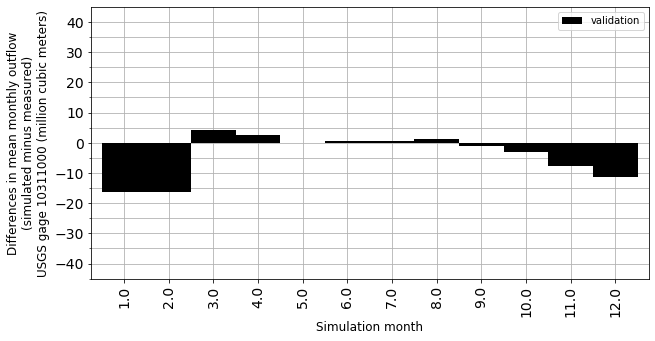

In [261]:
#ensure order
a=pd.DataFrame(d.copy())
a.columns=['validation']
a=a*cft2Mm3
a['month']=a.index.month
momean=a.loc[scend8s,['month','validation']].groupby('month').mean()*30

leg=['validation']
fig,ax=plt.subplots(1,1,figsize=figsize)
momean.plot(kind='bar',width=1,ax=ax,figsize=figsize,color=['k'])
ax.set_xlabel('Simulation month',fontsize=12)
ax.set_ylabel('Differences in mean monthly outflow\n(simulated minus measured)\nUSGS gage 10311000 (million cubic meters)',fontsize=12)
ytick = range(-45,45,5)
ax.set_ylim(-45,45)
ax.set_yticks(ytick, minor=True )
ax.grid('on', which='both', axis='both' )
ax.tick_params(labelsize=14)
ax.set_axisbelow(True)
ax.legend(leg)
plt.savefig(r'S:\CarsonValley\manuscripts\2020WR027924_final_figures\2020WR027924-validation.eps', format='eps')

## heads

In [168]:
simhead=pd.read_csv(os.path.join('..\\..\\','output','output_MSGSF_hist','CV-wes-8015trans-headsim.txt'),
                     delim_whitespace=True,names=['site','date','time','head'])
simhead.date=pd.to_datetime(simhead.date)
obshead=pd.read_csv(os.path.join('..\\','GW head','CV-wes-8015trans-headobs.txt'))
obshead.index=obshead.obsnme
# these are aligned, but some were dropped (i.e. ob_116_1 to ob_116_4), just use obsnme from obshead
simhead.index=obshead.index

In [183]:
len(simhead.site.unique())

228

In [169]:
obshead.head()

,obsnme,head,date,time
obsnme,,,,
ob_10_1,ob_10_1,4826.31465,1988-07-07,00:00:00
ob_10_2,ob_10_2,4826.19465,1998-04-30,00:00:00
ob_103_1,ob_103_1,5190.51740,2005-11-15,00:00:00
ob_103_2,ob_103_2,5214.27740,2006-05-18,00:00:00
ob_103_3,ob_103_3,5211.65740,2006-11-20,00:00:00


In [170]:
res=simhead.loc[:,'head']-obshead.loc[:,'head']

In [171]:
rmse=((res**2).mean()**0.5)/3.28084
print('rmse head (m): {} for {} obs'.format(rmse,len(res)))

rmse head (m): 10.185813058515281 for 7549 obs


## validation period (no calib period)

In [178]:
idx=[i for i in simhead.index if simhead.loc[i,'date']>datetime.date(2005,10,1) or simhead.loc[i,'date']<datetime.date(2000,9,30)]
rmse=((res.loc[idx]**2).mean()**0.5)/3.28084
q25=res.loc[idx].quantile(q=0.25)/3.28084
q75=res.loc[idx].quantile(q=0.75)/3.28084
print('rmse head (m): {} for {} obs'.format(rmse,len(idx)))
print('qrmse head : {} for {} obs'.format(rmse/(q75-q25),len(idx)))

rmse head (m): 9.895186061802072 for 6753 obs
qrmse head : 1.7775026795160693 for 6753 obs


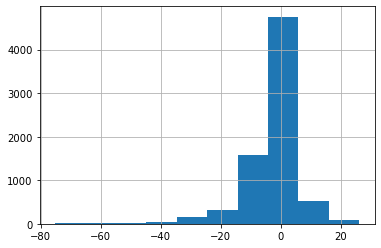

In [179]:
res.divide(3.28084).hist()

In [180]:
from scipy import stats
nres=res[(np.abs(stats.zscore(res)) < 2)]
idx=[i for i in nres.index if simhead.loc[i,'date']>datetime.date(2005,10,1) or simhead.loc[i,'date']<datetime.date(2000,9,30)]
rmse=((nres.loc[idx]**2).mean()**0.5)/3.28084
q25=nres.loc[idx].quantile(q=0.25)/3.28084
q75=nres.loc[idx].quantile(q=0.75)/3.28084
print('rmse head (m): {} for {} obs'.format(rmse,len(idx)))
print('qrmse head : {} for {} obs'.format(rmse/(q75-q25),len(idx)))

rmse head (m): 6.185639669181824 for 6371 obs
qrmse head : 1.241271888125768 for 6371 obs


In [181]:
nres.mean()

-6.113362491563616

## calibration period 

In [184]:
idx=[i for i in simhead.index if simhead.loc[i,'date']<datetime.date(2005,10,1) and simhead.loc[i,'date']>datetime.date(2000,9,30)]
rmse=((res.loc[idx]**2).mean()**0.5)/3.28084
print('rmse head (m): {} for {} obs'.format(rmse,len(idx)))

rmse head (m): 12.379909480544507 for 796 obs


# Old processing crap

In [ ]:
def water_year(m,y):
    if m<10:
        return(str(y))
    else:
        return(str(y+1))

In [ ]:
def water_yrmo(m,y):
    return(y*100+m)

In [ ]:

simstart=datetime.date(1979,7,2)
#sim inflow and outflow
sim={}
for scen in scenlist:
    print(scen)
    serlist=[]
    sites=['10311000','10309000','10310000']
    names=['outflow','efin','wfin']
    for name,site in zip(names,sites):
        ser=CV_tools.ts2df(site,'.sgag',simstart,rpath=os.path.join(scens[scen])).flow
        ser=ser.resample('D').mean().interpolate('backfill')
        #convert immediately
        serlist.append(ser.multiply(cft2Mm3))
    sim[scen]=pd.concat(serlist,axis=1)
    sim[scen].columns=names
    sim[scen]['accdep']=sim[scen]['outflow']-(sim[scen]['efin']+sim[scen]['wfin'])

In [ ]:
for scen in sim:  
    ax=sim[scen]['accdep'].plot(fontsize=14)
    ax=plt.title('Accretion and Depletion: {}'.format(scen))
    ax=plt.ylabel('million cubic meters per day')
ax=plt.legend(sim.keys())

In [ ]:
#inflows
for scen in scenlist:
    tribs=[]
    names=[]
    for f in os.listdir(os.path.join('..\\..\\','model','tabfiles_'+scen)):
        if 'regression' in f:
            site=f.split('-')[3]
            t=CV_tools.ts2df(site,'.sgag',simstart,rpath=os.path.join(scens[scen])).flow
            t=t.multiply(cft2Mm3)
            #t=pd.DataFrame(t)
            tribs.append(t.resample('D').mean().interpolate())            
            
            names.append(site)
                
    sim[scen]=pd.concat(tribs,axis=1,names=names)
    sim[scen]['year']=sim[scen].index.year
for scen in sim:
    print(sim[scen].groupby('year').sum().sum(axis=1).mean())

In [ ]:
figsize=(10,5)
annout={}
dif={}
cum={}
cumdif={}
mout={}
mdif={}
ymout={}
ymdif={}
#historical first
scen='0C'
sim[scen]['date']=sim[scen].index
sim[scen]['month']=sim[scen]['date'].dt.month
sim[scen]['year']=sim[scen]['date'].dt.year
sim[scen]['wy']=sim[scen].apply(lambda x: water_year(x['month'],x['year']),axis=1)
sim[scen]['wymo']=sim[scen].apply(lambda x: water_yrmo(x['month'],x['year']),axis=1)
cum[scen]=sim[scen]['outflow'].cumsum()
annout[scen]=sim[scen].loc[:,['outflow','wy']].groupby('wy').sum()
mout[scen]=sim[scen].loc[:,['outflow','month']].groupby('month').sum()
ymout[scen]=sim[scen].loc[:,['outflow','wymo']].groupby('wymo').sum()
#now scenarios
for scen in scenlist:
    sim[scen]['date']=sim[scen].index
    sim[scen]['month']=sim[scen]['date'].dt.month
    sim[scen]['year']=sim[scen]['date'].dt.year
    sim[scen]['wy']=sim[scen].apply(lambda x: water_year(x['month'],x['year']),axis=1)
    sim[scen]['wymo']=sim[scen].apply(lambda x: water_yrmo(x['month'],x['year']),axis=1)
    
    cum[scen]=sim[scen]['outflow'].cumsum()
    cumdif[scen]=cum[scen]-cum['0C']
    annout[scen]=sim[scen].loc[:,['outflow','wy']].groupby('wy').sum()
    dif[scen]=annout[scen]-annout['0C']
    mout[scen]=sim[scen].loc[:,['outflow','month']].groupby('month').sum()
    mdif[scen]=mout[scen]-mout['0C']
    ymout[scen]=sim[scen].loc[:,['outflow','wymo']].groupby('wymo').sum()
    ymdif[scen]=ymout[scen]-ymout['0C']

In [ ]:
for scen in scenlist:
    outflow=sim[scen].loc[:,['year','outflow']].groupby('year').sum()
    print(float(outflow.loc[scenyrs,:].mean()))

In [ ]:
a=pd.concat(dif,axis=1,ignore_index=True)
a.columns=scenlist

In [ ]:
leg=[]
fig,ax=plt.subplots(1,1,figsize=figsize)
a.loc[a.index!=1979,['1C','2C','3C','4C','5C']].plot(kind='bar',width=1,ax=ax,figsize=figsize,color=['b','c','g','m','r'])
ax.set(xlabel='Simulation water year',ylabel='Difference in annual outflow\nUSGS gage 10311000 (hectare-meters)')
ytick = range(-2500,7500,500)
#ax.set_yticks(ytick, minor=True )
ax.grid('on', which='both', axis='both' )
ax.tick_params(labelsize=14)
ax.set_axisbelow(True)

In [ ]:
nyrs=(sim['0C'].index[-1]-sim['0C'].index[0]).days/365.2455

In [ ]:
# 35-year average change in annual inflow
for scen in mdif:
    0C=(sim['0C'].loc[:,'efin']+sim['0C'].loc[:,'wfin']).sum()/nyrs
    fd=(sim[scen].loc[:,'efin']+sim[scen].loc[:,'wfin']-((sim['0C'].loc[:,'efin']+sim['0C'].loc[:,'wfin']))).sum()/nyrs
    print(scen,0C,fd,fd/0C)

In [ ]:
# 35-year average change in annual outflow
for scen in sim:
    0C=sim['0C'].loc[:,'outflow'].sum()/nyrs
    fd=(sim[scen].loc[:,'outflow']-sim['0C'].loc[:,'outflow']).sum()/nyrs
    print(scen,0C,fd,fd/0C)

In [ ]:
# 35-year average change in irrigation season inflow
mask=[m for m in sim['0C'].index if sim['0C'].loc[m,'month']>3 and sim['0C'].loc[m,'month']<10]
   
for scen in sim:
    0C=(sim['0C'].loc[mask,'efin']+sim['0C'].loc[mask,'wfin']).sum()/nyrs
    fd=(sim[scen].loc[mask,'efin']+sim[scen].loc[mask,'wfin']-((sim['0C'].loc[mask,'efin']+sim['0C'].loc[mask,'wfin']))).sum()/nyrs
    print(scen,0C,fd,fd/0C)

In [ ]:
# 35-year average change in irrigation season outflow
mask=[m for m in sim['1C'].index if sim['1C'].loc[m,'month']>3 and sim['1C'].loc[m,'month']<10]
   
for scen in sim:
    0C=sim['0C'].loc[mask,'outflow'].sum()/nyrs
    fd=(sim[scen].loc[mask,'outflow']-sim['0C'].loc[mask,'outflow']).sum()/nyrs
    print(scen,0C,fd,fd/0C)

In [ ]:
dates=[datetime.date(1982,10,1),datetime.date(1986,10,1)]
yrmos=[i.year*100+i.month for i in dates]

fig,ax=plt.subplots(1,1,figsize=(10,5))
b=pd.concat([ymdif['1C'],ymdif['3C'],ymdif['5C']],axis=1,ignore_index=True)
b.columns=['1C','3C','5C']

b.loc[yrmos[0]:yrmos[1]].plot(ax=ax,kind='bar',figsize=(10,5),width=0.75)
ax.grid('on', which='both', axis='both' )
ax.set_axisbelow(True)
ax.set(xlabel='Simulation year and month (YEARMO)',ylabel='Difference in cumulative montly outlfow\nUSGS gage 10311000 (hectare-meters)')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(10,5))
b=pd.concat([ymout['0C'],ymout['1C'],ymout['3C'],ymout['5C']],axis=1,ignore_index=True)
b.columns=['0C','1C','3C','5C']

b.loc[yrmos[0]:yrmos[1]].plot(ax=ax,kind='bar',figsize=(10,5),width=0.75)
ax.grid('on', which='both', axis='both' )
ax.set_axisbelow(True)
ax.set(xlabel='Simulation year and month (YEARMO)',ylabel='Cumulative monthly outlfow\nUSGS gage 10311000 (hectare-meters)')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=figsize)
sim['0C'].loc[dates[0]:dates[1],'efin'].plot(ax=ax)
sim['3C'].loc[dates[0]:dates[1],'efin'].plot(ax=ax)
sim['5C'].loc[dates[0]:dates[1],'efin'].plot(ax=ax)
ax.legend(['historical','3C','5C'])
ax.set(xlabel='Simulation date',ylabel='East Fork Flows\nUSGS gage 10309000\n(hectare-meters per day)')

In [ ]:
fig,ax=plt.subplots(1,1,figsize=figsize)
mo=pd.concat([mdif[s].divide(nyrs) for s in mdif if '0C' not in s],axis=1,ignore_index=True)
mo.columns=[s for s in scenlist if '0C' not in s]

mo.plot(ax=ax,kind='bar',figsize=(10,5),width=0.75,color=['b','g','c','m','r'])
ax.grid('on', which='both', axis='both' )
ax.set_axisbelow(True)
ax.set(xlabel='Simulation month',ylabel='Difference in monthly outlfow\nscenario minus historical\nUSGS gage 10311000 (hectare-meters)')

fig.savefig(os.path.join(resdir,'dT_out_dif.png'), dpi=600,bbox_inches='tight')

In [ ]:
for scen in mo:
    print(scen,mo[scen])

In [ ]:
cumsum=pd.concat(cum,axis=1,ignore_index=True)
cumsum.columns=scenlist

fig,ax=plt.subplots(1,1,figsize=figsize)
cumsum.plot(ax=ax)
ax.set(xlabel='Simulation date',ylabel='Cumulative outlfow\nUSGS gage 10311000 (hectare-meters)')

In [ ]:
cd=[]
col=[]
fig,ax=plt.subplots(1,1,figsize=figsize)
for scen in cumsum:
    if scen!='0C':
        cd.append(cumsum[scen]-cumsum['0C'])
        col.append(scen)
cumdif=pd.concat(cd,axis=1,ignore_index=True)
cumdif.columns=col
cumdif.plot(ax=ax,color=['b','g','c','m','r'])
ax.legend(bbox_to_anchor=(.5, .95),loc='center',ncol=len(scenlist)-1)
ax.grid('on', which='both', axis='both' )
ax.set(xlabel='Simulation water year',ylabel='Difference in cumulative outflow from historical\nUSGS gage 10311000 (hectare-meters)')

fig.savefig(os.path.join(resdir,'dT_cumout_dif.png'), dpi=600,bbox_inches='tight')

In [ ]:
cumdif.iloc[-1,:]

# AG delivery analysis
Stacked bar graph of ag deliveries (SW+GW+GWET) binned by priority decade
0Cogram of annual deliveries in feet

In [ ]:
pmp=[o for o in obs.index if obs.loc[o,'obgnme']=='pmp']
obs.loc[pmp,'rwell']=obs.loc[pmp,'obsnme'].apply(lambda x: x.split('_')[0])
obs.loc[pmp,:].head()

In [ ]:
wlist=list(set(obs.loc[:,'rwell']))
df=obs.loc[obs['rwell'].isin(wlist),:]       

In [ ]:
df.head() 

In [ ]:
wrdf.head()

In [ ]:
df.loc[df['wryr']>1800,:].hist(bins=range(1850,1930,10))
plt.ylabel('number of wells')
plt.xlabel('WR priority year')

In [ ]:
k='fracsup_sw'
ps=[p for p in pars.index if k in pars.loc[p,'pargp']]
pen['9'].loc[ps,:].mean(axis=1).hist()
plt.xlabel('calibrated {} parameter'.format(k))
plt.ylabel('number of values')